# WoT Proxy 

The implementation of a Web of Things Proxy involves a structured and progressive design process aimed at integrating physical devices (sensors and actuators) into the web ecosystem. This process transforms low-level embedded devices into first-class web citizens, accessible and controllable via standardized interfaces. The implementation path proceeds through **five tightly interconnected design dimensions**, each responsible for a different layer of abstraction and functionality.

The first step is the **Integration Strategy**, where a decision is made on how the physical devices, referred to as Things, will connect to the Internet and the Web. This choice depends on the capabilities of the devices themselves. Some can implement web protocols like HTTP or WebSockets natively, while others, due to power or computational constraints, require the support of an intermediary such as a gateway or a cloud platform. The selected integration pattern (direct, gateway-based, or cloud-based) defines how the Thing exposes its services to the web.

Once connectivity is defined, **Resource Design** organizes the Thing functionalities into logical services. These are modeled as REST resources, mapping the physical components into a hierarchical structure that mirrors their digital representation. The design must consider what resources are exposed, how they are grouped, and the semantic meaning associated with each endpoint.

After resources are identified, **Representation Design** focuses on the format in which data is exchanged. Since RESTful architectures are agnostic to representation, the server can support multiple formats such as JSON, HTML, or the compact binary format MessagePack. This design step enables content negotiation and ensures compatibility with a wide range of clients, including those operating in constrained environments.

The **Interface Design** extends the expressivity of the API beyond simple data retrieval. It introduces support for HTTP verbs like PUT and POST, enabling interaction with actuators and other mutable resources. Additionally, it defines error handling mechanisms and status codes, and may introduce asynchronous communication models using WebSockets to support real-time updates from sensors.

Lastly, **Resource Linking Design** establishes relationships among resources, allowing clients to navigate the Thing API through hypermedia links. This enriches the interface by making it self-descriptive and discoverable, aligning with the REST constraint of HATEOAS (Hypermedia as the Engine of Application State).

Together, these design steps constitute the foundation of a scalable and interoperable WoT architecture. They are not isolated phases but interdependent layers that must be coherently aligned to transform embedded devices into services integrated seamlessly with the Web.

## Integration Strategy

The integration strategy establishes how the API of a physical Thing is exposed on the Web, based on its networking capabilities and hardware constraints. It determines whether the Thing can serve requests directly, needs support from a gateway, or relies on cloud infrastructure. This decision shapes the overall architecture of a Web of Things system.

### Direct Integration Pattern

In the direct integration pattern, the Thing is **capable of implementing Web protocols on its own**. It exposes a Web API directly over HTTP or WebSockets and handles requests without intermediaries. This is the cleanest and most interoperable setup, suitable for devices that can afford the necessary memory, processing power, and energy consumption:

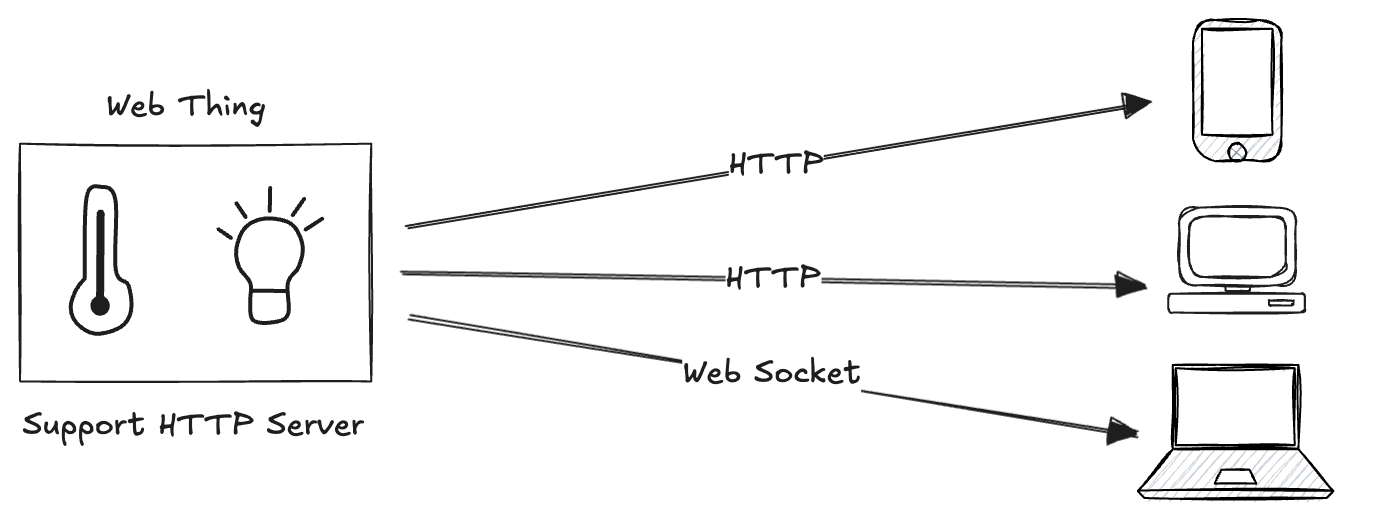

For example, a Raspberry Pi equipped with a temperature sensor runs an Express.js server. It exposes a RESTful API where clients can perform "GET /temperature" to retrieve current readings, or "POST /log" to store data remotely. The Pi handles HTTP and WebSocket requests natively and serves responses using JSON or HTML.

This approach is ideal in local networks where latency must be minimized, or where the Thing must interact with other Web components directly. However, it assumes reliable connectivity and sufficient system resources.

### Gateway Integration Pattern

Many Things (such as small microcontrollers) cannot support HTTP or TCP/IP stacks due to **hardware limitations**. In these cases, a gateway device is introduced to act as a **bridge**. It communicates with the constrained Things using low-power protocols (like Bluetooth, ZigBee, or even serial) and exposes their data through a unified Web API:

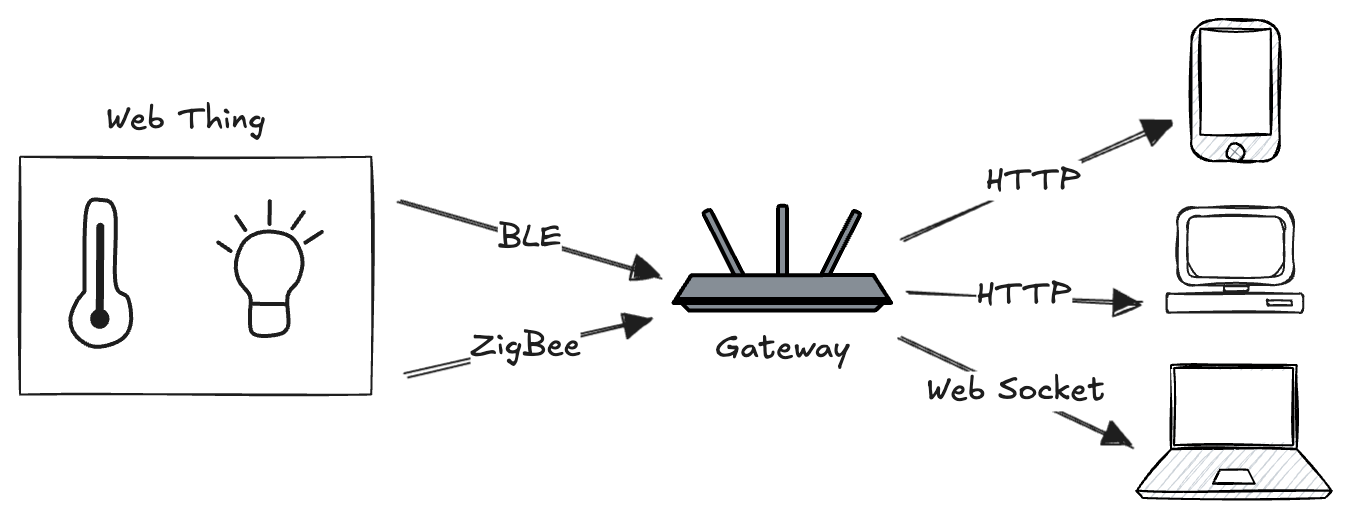

For Example, several Arduino boards equipped with sensors communicate via serial over USB with a Node.js-based gateway running on a laptop or embedded controller. The gateway collects sensor values and exposes them as REST resources (e.g., "GET /sensors/light", "PUT /actuators/led") on an HTTP interface. Clients only interact with the gateway, which abstracts the complexity of the underlying devices.

This pattern also allows for protocol translation, caching, or security filtering and is a key enabler of so-called **fog computing architectures**, where intermediate devices process data near the edge of the network.

### Cloud Integration Pattern

When devices **can connect to the Internet** but **lack sufficient capabilities** to expose a full Web API, cloud integration becomes a viable alternative. Devices push data to a cloud platform using lightweight protocols such as MQTT or HTTPS, and the cloud platform exposes this data through REST APIs to client applications:

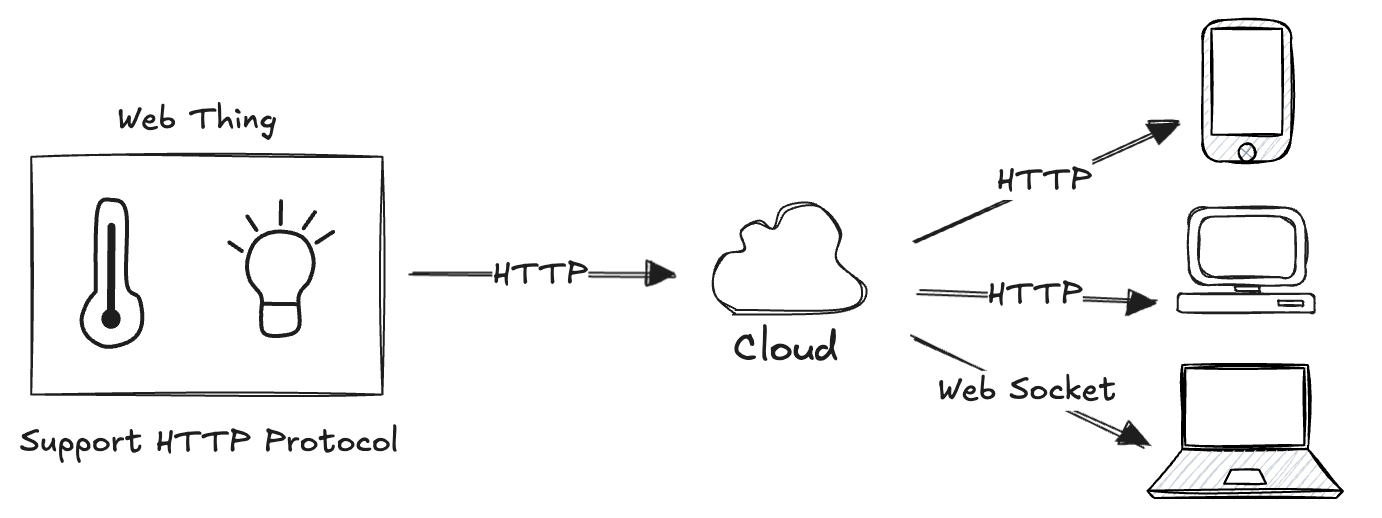

For Example, a battery-powered ESP32 board collects environmental data and periodically sends it to Measurify ([https://measurify.org/](https://measurify.org/)), a cloud platform designed for Things. Measurify stores the measurements and offers a RESTful API to access them. Clients can retrieve current and historical data using calls like "GET /things/id/measurements".

This strategy is particularly **suitable for large-scale deployments** where scalability, persistence, and global accessibility are priorities. It offloads the processing burden from constrained devices and allows for powerful analytics or dashboards to be built on top of the exposed APIs.

### Design decision

Each strategy offers a different level of abstraction and system complexity. While direct integration is optimal for small, self-contained systems, gateway and cloud approaches enable the incorporation of highly constrained or widely distributed devices into the Web of Things ecosystem. The choice depends on the application requirements and the capabilities of the deployed hardware. 

For our Web Proxy implementation, we will use the **Gateway Integration Pattern**. This allows us to abstract the complexity of the underlying devices and expose a unified Web API for clients to interact with. The gateway will handle communication with the constrained Things and provide a seamless interface for clients to access their data and functionalities.

## Resource Design

Resource Design is the process of organizing and exposing the capabilities of a physical Thing as web-accessible REST resources. This step is foundational in bridging the physical and digital realms, allowing sensors and actuators embedded in a device to be accessed through structured URLs. It begins by identifying the physical elements of the system (such as LEDs, temperature sensors, or motion detectors) and mapping each of them into the corresponding logical entities under a coherent URI hierarchy. In the case of our WoT Proxy, we will focus on a simple architecture that includes sensors and actuators:

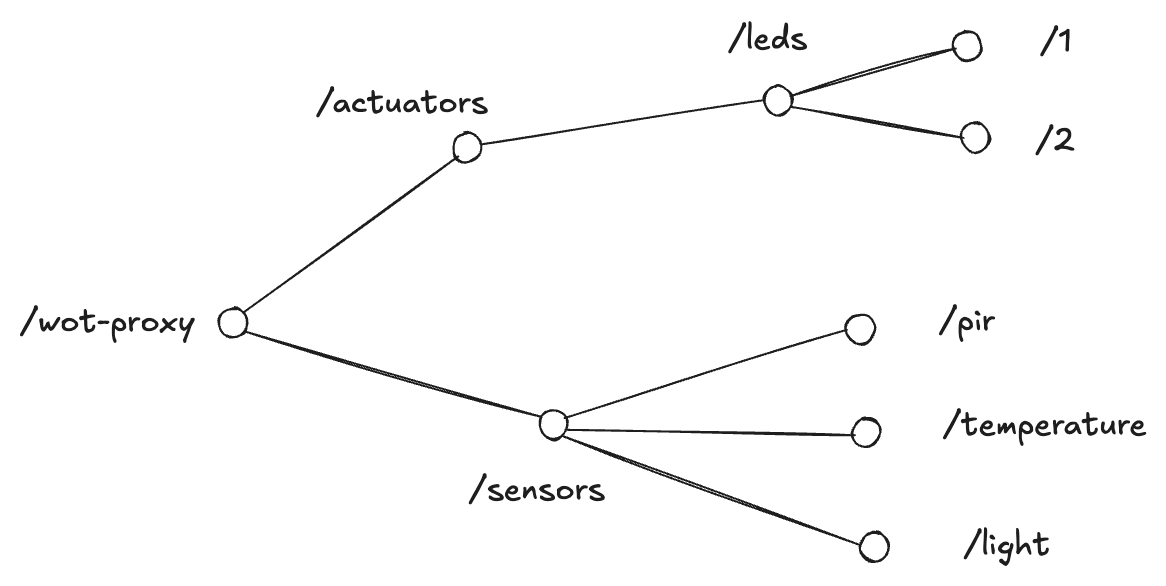

The entry point of the REST API is typically a **root URL**, such as "http://wot-proxy", which serves as the base path for all resources. From there, the API branches into two main categories: **sensors** and **actuators**. This categorization reflects the distinct roles that physical components play in an IoT system: sensors collect data from the environment, while actuators modify it.

Under the "/sensors" path, different sensing components are exposed as sub-resources. For example, a passive infrared sensor (PIR) might be available at "/sensors/pir", a temperature sensor at "/sensors/temperature", and a light sensor at "/sensors/light". These endpoints return data (typically in JSON format) that represents the current state of each physical sensor.

Similarly, the "/actuators" path groups controllable elements, such as LEDs, which are exposed under "/actuators/leds". If multiple instances of the same actuator exist, they can be identified using additional paths, such as "/actuators/leds/1" and "/actuators/leds/2".

The design benefits from a clean and hierarchical structure, which enhances **discoverability** and **navigability** of the API. Moreover, it **reflects the physical layout** of the Thing in a logical, web-friendly way. This structure allows developers and client applications to interact with complex embedded systems using simple and intuitive web requests.

In summary, Resource Design transforms a physical device components into a well-organized tree of web resources. Each element becomes addressable, manipulable, and observable through standard web protocols, thereby enabling true interoperability in the Web of Things.

## Simple Thing

We can start the implmentation of our WoT Proxy. This project structure should be organized in a **modular** and **clean** way according to the core responsibilities of the system. The structure has to separate the configuration of the resources, the routing, and server logic, which is a best practice for maintainability and scalability:

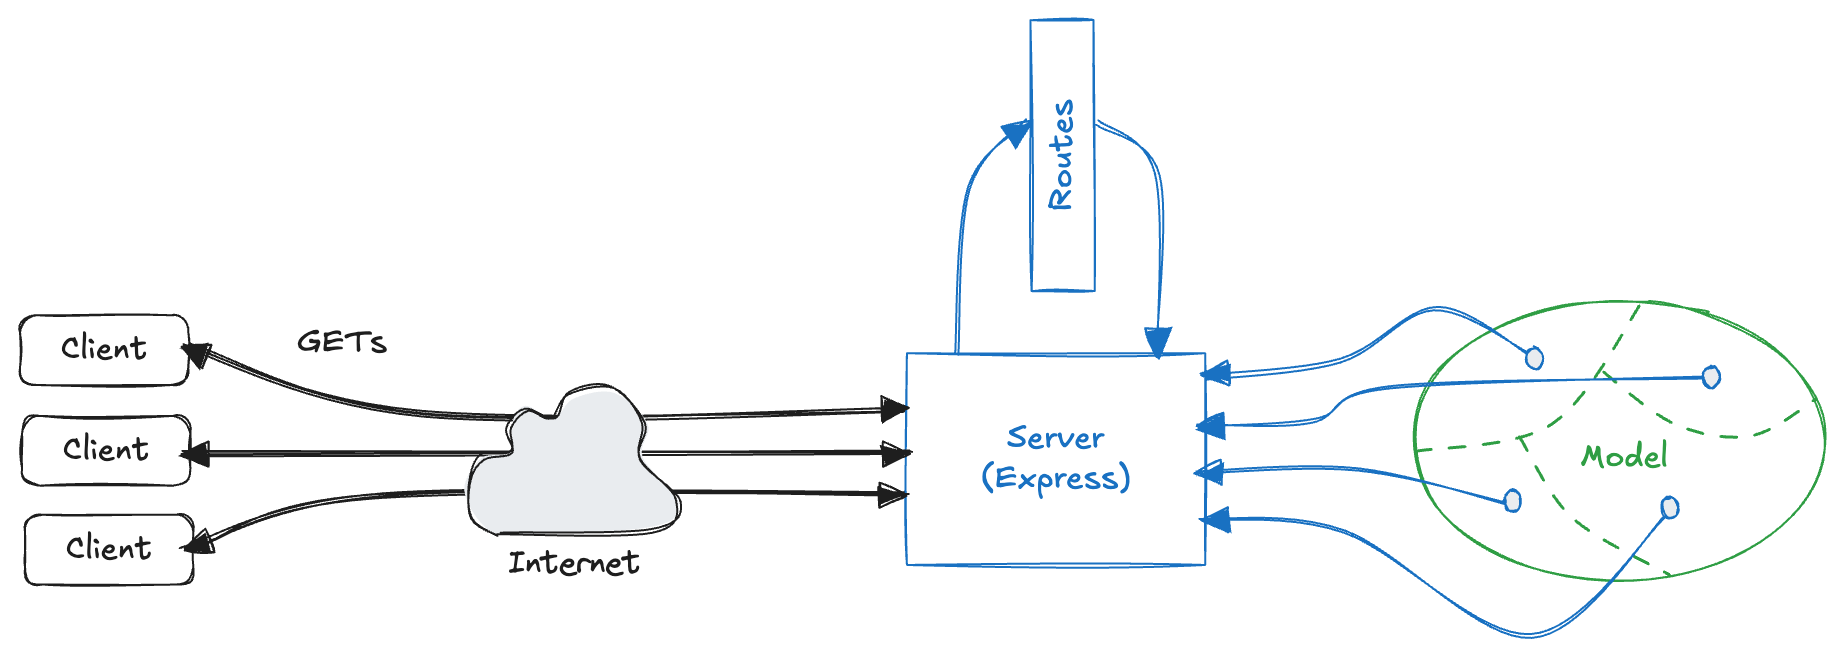

This architecture enables future extensions, such as adding new resources or supporting additional representation formats, with minimal restructuring (see 01.Simple Thing code):

### Entry point

The **wot-server.js** file is the main entry point of the proxy. It initializes the server, loads a resource model (that we need to design), and ties together all components into a running system. It is the central coordination script for the application:

In [ ]:
// wot-server.js

 // Load the http server and the model
 const httpServer = require('./servers/http');
 const resources = require('./resources/model');

 // Start the HTTP server by invoking listen() on the Express application
 const server = httpServer.listen(resources.iot.port, function () {
  // Once the server is started the callback is invoked
  console.info('Your WoT API is up and running on port %s', resources.iot.port);
 });

### Servers

The **servers/** folder contains the server code, which is responsible for handling incoming requests and routing them to the appropriate handlers. It also manages the server's lifecycle, including starting and stopping the server. At the moment, we have only a single HTTP server, but we can add more servers in the future if needed. In particular, the **http.js** file wraps an HTTP server using the Express framework:

In [ ]:
// /servers/http.js

// Requires the Express framework, your routes, and the model
const express = require('express');
const actuatorsRoutes = require('./../routes/actuators');
const sensorRoutes = require('./../routes/sensors');

// Creates an application with the Express framework
// this wraps an HTTP server
const app = express();

// Binds your routes to the Express application
// bind them to /pi/actuators/... and /pi/sensors/...
app.use('/iot/actuators', actuatorsRoutes);
app.use('/iot/sensors', sensorRoutes);

// Create a default route for /pi
app.get('/iot', function (req, res) {
  res.send('This is the WoT API!')
});

// We export router to make it accessible for "requirers" of this file
module.exports = app;

### Resources

The **resources/** folder defines the resource model of the system. The configuration file **resources.json**
declares the hierarchy and identifiers of the available sensors and actuators. This file functions as a digital twin of the physical setup, describing the device tree in a structured format. It plays a crucial role in separating the **hardware logic** (i.e., interaction with real sensors) from the **web interface logic** (i.e., how sensor values are exposed via HTTP routes):

In [ ]:
{
  "iot": {
    "name": "MyWoT",
    "description": "A simple WoT API",
    "port": 8484,
    "sensors": {
      "temperature": {
        "name": "Temperature Sensor",
        "description": "An ambient temperature sensor.",
        "unit": "celsius",
        "value": 0
      },
      "light": {
        "name": "Light Sensor",
        "description": "An ambient light sensor.",
        "unit": "%",
        "value": 0
      },
      "pir": {
        "name": "Passive Infrared",
        "description": "A passive infrared sensor. When 'true' someone is present.",
        "value": true
      }
    },
    "actuators": {
      "leds": {
        "1": {
          "name": "LED 1",
          "value": false
        },
        "2": {
          "name": "LED 2",
          "value": false
        }
      }
    }
  }
}

The **model.js** module loads and manages the configuration defined in resources.json. It may offer helper functions to access and update the state of individual resources in memory:

In [ ]:
// /resources/model.js

// We load the entire data model from other files (here only resources.json)
const resources = require('./resources.json');

// We export the resources to make it accessible for "requirers" of this file
module.exports = resources;

The model serves as an **in-memory representation** of the state of the Thing. It is loaded into the application via model.js, which provides functions to read or update values programmatically. We need to write code to interact with the real hardware, updating the model when a new value is read. At the same time, route handlers ** do not interact with the hardware directly**. Instead, they simply read from or write to the model. This design ensures that **real-world hardware is abstracted away from the web layer**. In this way we expose a consistent and predictable API, regardless of whether the device is running in simulation mode or connected to real sensors.

### Routes

The **routes/** folder contains the **route definitions** for the Express.js application:

- **sensors.js** handles the routes under /sensors. 
- **actuators.js** manages the HTTP endpoints under /actuators. 

These modules define the URL structure and link the external API to internal logic, following the REST design principles.

In [ ]:
// /routes/sensors.js

const express = require('express');

// We require and instantiate an Express Router to define the path to our resources
const router = express.Router();

// We require the model
const resources = require('./../resources/model');

// Create a new route for a GET request on all sensors and attach a callback function
router.route('/').get(function (req, res, next) {
  // Reply with the sensor model when this route is selected
  res.send(resources.iot.sensors);
});

// This route serves the passive infrared sensor
router.route('/pir').get(function (req, res, next) {
  res.send(resources.iot.sensors.pir);
});

// This routes serve the temperature sensor
router.route('/temperature').get(function (req, res, next) {
  res.send(resources.iot.sensors.temperature);
});

// This routes serve the light sensor
router.route('/light').get(function (req, res, next) {
  res.send(resources.iot.sensors.light);
});

// We export router to make it accessible for "requirers" of this file
module.exports = router;

In [ ]:
// /routes/actuators.js

const express = require('express');

// We require and instantiate an Express Router to define the path to our resources
const router = express.Router();

// We require the model
const resources = require('./../resources/model');

// Create a new route for a GET request
router.route('/').get(function (req, res, next) {
 // Reply with the actuators model when this route is selected
 res.send(resources.iot.actuators);
});

// This route serves a list of LEDs
router.route('/leds').get(function (req, res, next) {
  res.send(resources.iot.actuators.leds);
});

// With :id we inject a variable in the path which will be the LED number
router.route('/leds/:id').get(function (req, res, next) {
  // The path variables are accessible via req.params.id
  // we use this to select the right object in our model and return it
  res.send(resources.iot.actuators.leds[req.params.id]);
});

// We export router to make it accessible for "requirers" of this file
module.exports = router;

### Benefits

This architectural approach offers several key advantages that contribute to the robustness and flexibility of the WoT Proxy:

- **Separation of concerns**: Hardware drivers and web routes are logically and physically independent, allowing each to evolve without interfering with the other.

- **Simulation support**: Simulated sensors can update the model exactly as real sensors would, enabling development and testing even in the absence of physical hardware.

- **Maintainability**: Changes made to the hardware layer (e.g., swapping or reconfiguring sensors) do not require modifications to the routing logic, and vice versa.

- **Testability**: Since the model operates as a shared state, it can be programmatically tested and manipulated without needing to access real devices.

In summary, "resources.json" acts as a **digital twin** of the physical device, serving as the central point of integration between real-time sensor data and web-based interaction in the WoT Proxy architecture.

## Bind the sensors

At this stage, the WoT Proxy architecture successfully exposes the digital model of sensors and actuators via RESTful routes. However, what is still missing is the **connection to the real world**: the actual sensor values remain static as defined in resources.json. Binding the sensors means **making the resource model dynamic** by linking it to physical or simulated hardware, so that the values returned by the API reflect the current state of the real environment. This is accomplished by implementing and integrating **sensor plugins**. Each plugin is responsible for reading data from one specific sensor (e.g., temperature, light, or PIR) and updating the shared resource model accordingly (see 02.Bind sensors code):

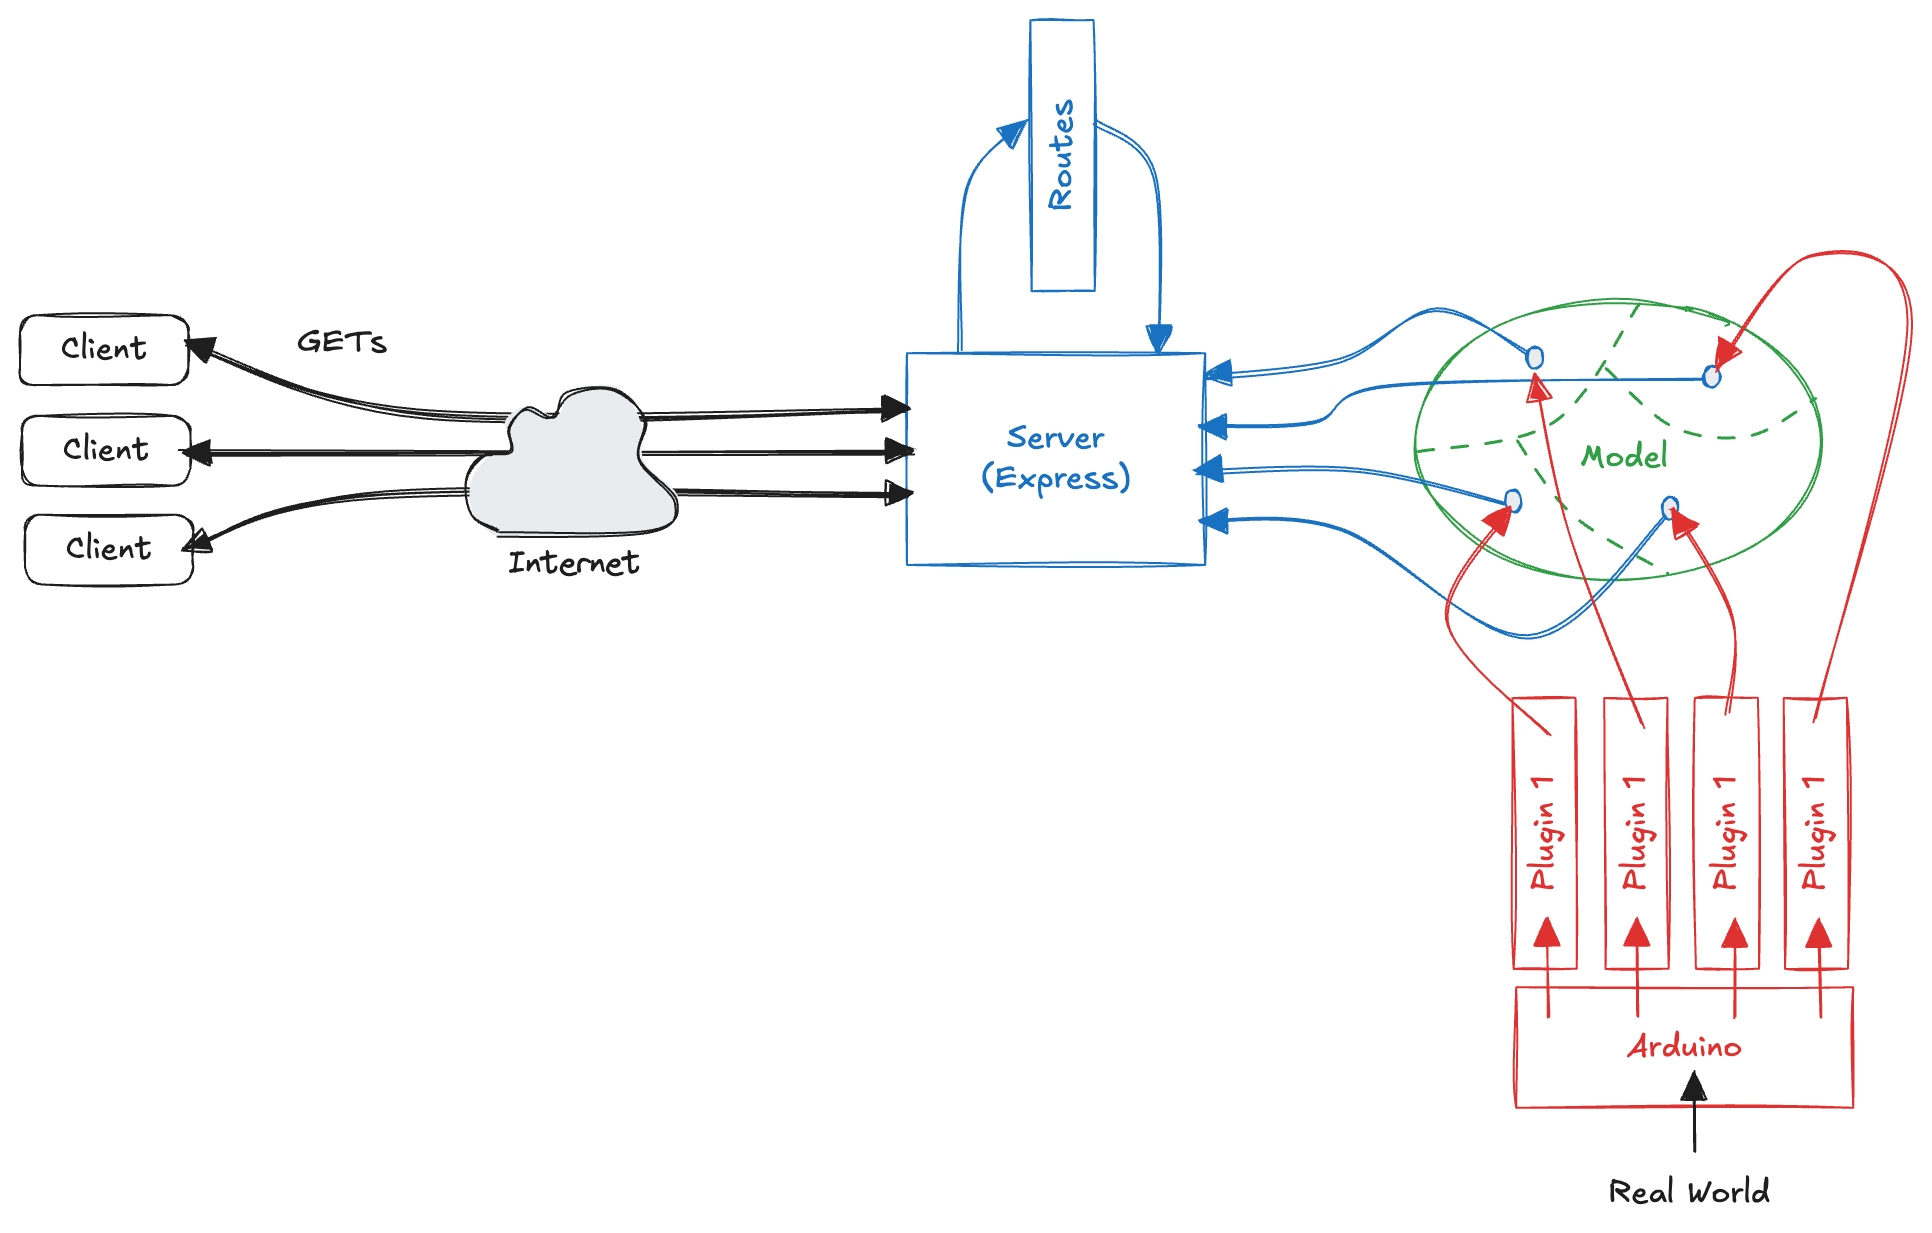

### Plugin Structure

A plugin is a standalone module (e.g., /plugins/tempPlugin.js) that **encapsulates the logic required to read from the sensor and update the corresponding field** in the model. To ensure flexibility and reusability, each plugin follows a common structure and exposes at least the following functions:

- start(): activates the plugin, starting the loop or callback that fetches sensor values and writes them into the model.
- stop(): stops the sensor reading, useful for cleanup or shutdown.
- connectHardware(): initializes communication with the physical device and configures it.
- simulate(): provides simulated values, useful for development without access to real hardware.

Plugins are typically stored in the **plugins/** folder, with separate files for each sensor or actuator. For example, we can consider the temperature sensor plugin (tempPlugin.js):

In [ ]:
// /plugins/temperature.js

const resources = require('./../resources/model');

let interval;
const model = resources.iot.sensors.temperature;
const pluginName = resources.iot.sensors.temperature.name;
const unit = resources.iot.sensors.temperature.unit;
let localParams = {'simulate': true, 'frequency': 2000};

// Starts the plugin, should be accessible from other
// files so we export them
exports.start = function (params) {
  localParams = params;
  if (localParams.simulate) { simulate(); } 
  else { connectHardware(); }
};

// Stop the plugin, should be accessible from other
// files so we export them
exports.stop = function () {
  clearInterval(interval);
  console.info('%s plugin stopped!', pluginName);
};

// Require and connect the actual hardware driver and configure it
function connectHardware() {
  let arduino = require('./../hardware/arduino');
  interval = setInterval(function () { model.value = arduino.temperature; }, localParams.frequency);
  console.info('Hardware %s sensor started!', pluginName);
};

// Allows the plugin to be in simulation mode. This is very useful when developing
// or when you want to test your code on a device with no sensors connected, such as your laptop
function simulate() {
  interval = setInterval(function () { model.value += 1; showValue(); }, localParams.frequency);
  console.info('Simulated %s sensor started!', pluginName);
};

function showValue() { console.info('%s value = %s %s', pluginName, model.value, unit); };

Other filea s in the **plugins/** folder are similar, each implementing the specific logic for their respective sensors or actuators. The plugins are loaded and started in the main entry point (wot-server.js) when the server is initialized:

In [ ]:
// wot-server.js

// Load the http server and the model
 const httpServer = require('./servers/http');
 const resources = require('./resources/model');

 // Require all the sensor plugins we need
 const ledsPlugin = require('./plugins/ledsPlugin');
 const pirPlugin = require('./plugins/pirPlugin');
 const tempPlugin = require('./plugins/tempPlugin');
 const lightPlugin = require('./plugins/lightPlugin');

 // Start them with a parameter object. Here we start them on a
 // laptop so we activate the simulation function
 ledsPlugin.start({'simulate': true, 'frequency': 2000});
 pirPlugin.start({'simulate': true, 'frequency': 1000});
 tempPlugin.start({'simulate': true, 'frequency': 1000});
 lightPlugin.start({'simulate': true, 'frequency': 1000});

 // Start the HTTP server by invoking listen() on the Express application
 const server = httpServer.listen(resources.iot.port, function () {
  // Once the server is started the callback is invoked
  console.info('Your WoT API is up and running on port %s', resources.iot.port);
 });

Notice that the start() function supports **two operational modes**, depending on whether the plugin should interact with **real hardware** or operate in **simulation**. This dual-mode architecture is **essential for development, testing, and deployment** in diverse environments.

### Real Hardware

In real-hardware operation mode, the plugin needs to connect to the physical device and start reading values. This is done **separating the plugin logic from the hardware-specific code**. The plugin itself does not need to know how to connect to the hardware; it simply calls the connectHardware() function, which is implemented in a separate module. This module handles the actual connection and data retrieval from the sensor.

Under the **/hardware** folder we have he code implements a complete **hardware-software bridge** between an Arduino board (acting as a real-world sensor and actuator interface) and the proxy server. This part can be adapted to any other hardware platform, such as Raspberry Pi, ESP32 without affecting the rest of the code. 

In particular, the **hardware.ino** code is an Arduino sketch that runs on the board. It handles real sensor data acquisition. It continuously reads values from a temperature sensor via I2C, a passive infrared (PIR) motion detector via digital input, and a light sensor via analog input. Every second, the Arduino sends a structured data string over the serial interface in the format:

In [ ]:
H;<temperature>;<motion>;<light>;

In [ ]:
// hardware.ino

#include <Wire.h>

const char HEADER = 'H';
int tmp102Address = 0x48;
int led1Pin = 6;
int led2Pin = 7;
int pirPin = 2;
int lightPin = 0;

void setup() {
  Serial.begin(9600);
  
  Wire.begin();
  
  pinMode(led1Pin, OUTPUT);
  pinMode(led2Pin, OUTPUT);
  pinMode(pirPin,  INPUT);
}

void loop() {
  float temperature = getTemperature();
  int motion = getMovement();
  float light = getLight();

  Serial.print(HEADER);
  Serial.print(";");
  Serial.print(temperature);
  Serial.print(";");
  Serial.print(motion);
  Serial.print(";");
  Serial.print(light);
  Serial.println(";");
   
  delay(1000); 
}

float getLight() {
  return  analogRead(lightPin); 
}

int getMovement() {
  int pirVal = digitalRead(pirPin);
  if(pirVal == LOW) return 1;
  else return 0;
}

float getTemperature(){
  Wire.requestFrom(tmp102Address,2); 
  byte MSB = Wire.read();
  byte LSB = Wire.read();
  int TemperatureSum = ((MSB << 8) | LSB) >> 4; 
  float celsius = TemperatureSum*0.0625;
  return celsius;
}

On the Node.js side, the **arduino.js** module uses the serialport to **read and parse incoming serial data**. It maintains a shared values object containing the most recent sensor values, extracted from each incoming line sent by the Arduino. The module exports this object, making it accessible to other parts of the application such as sensor plugins, which can update the RESTful resource model accordingly:

In [ ]:
// arduino.js

const serialport = require('serialport');
const readline = require('@serialport/parser-readline')
const portName = '/dev/cu.usbmodem1421';

const values = {  temperature:"0", 
                  light: "0", 
                  movement: "0" 
               }

const sp = new serialport(portName, {
    baudRate: 9600,
    dataBits: 8,
    parity: 'none',
    stopBits: 1,
    flowControl: false,
});

const parser = new readline();
sp.pipe(parser);

parser.on('data', function(input) {
    var res = input.split(";");
    
    if(res[0] == 'H'){
      values.temperature = res[1];
      values.movement = res[2];
      values.light = res[3];
    }
});

module.exports = values;

This approach allows sensor data to flow from the Arduino into the WoT Proxy without the server needing to poll or query for updates. Instead, it simply uses the latest values stored in memory. 

The overall architecture is clean and modular. The Arduino handles low-level sensing and control, while the Node.js application exposes those values over the web through a structured API. **This design separates concerns effectively**, ensuring that the physical device logic and the web logic remain independent and easy to maintain.

## Representation Design

In a RESTful architecture, the same resource can be represented in different formats depending on the client’s needs or capabilities. REST itself is **agnostic** to the specific data format used in the communication between client and server. This principle enables a Web of Things system to support **multiple representations** of the same resource, enhancing interoperability.

### Suopported formats

The default and most widely used representation is **JSON**, which ensures compatibility across systems and platforms due to its ubiquity and simplicity. JSON is essential to guarantee that clients (from web dashboards to mobile apps) can parse and use the data without requiring additional tooling. However, JSON is not the only useful representation.

Adding support for **HTML** representation allows human users to navigate and explore the API through a browser. Instead of seeing a raw JSON object, they can interact with a structured and readable HTML view. This **improves developer experience** and facilitates testing and debugging. For this purpose, a transformation library like "json2html" can be used to convert the model’s JSON objects into an HTML representation dynamically, without hardcoding HTML templates.

In more constrained environments (such as embedded devices with limited memory or bandwidth) [**MessagePack**](https://msgpack.org/) becomes a valuable alternative. It is a **binary serialization format** that maps cleanly to JSON but produces more compact payloads. This efficiency makes it especially suited for low-power IoT scenarios, where network usage needs to be minimized. On the server side, the "msgpack5" library can be used to support this representation seamlessly.

### Middleware implementation

To handle these multiple formats in a clean and extensible way, the server architecture relies on the **middleware pattern**. Middleware functions in Express are chained components that process the incoming request and outgoing response objects. Each middleware has access to the full context of the request and can either handle the response or pass control to the next function using "next()". In the context of representation design, a custom middleware can be introduced to examine the "Accept" header of the request and select the appropriate representation (e.g., "application/json", "text/html", or "application/x-msgpack"). The selected format determines how the resource is encoded before it is sent in the response:

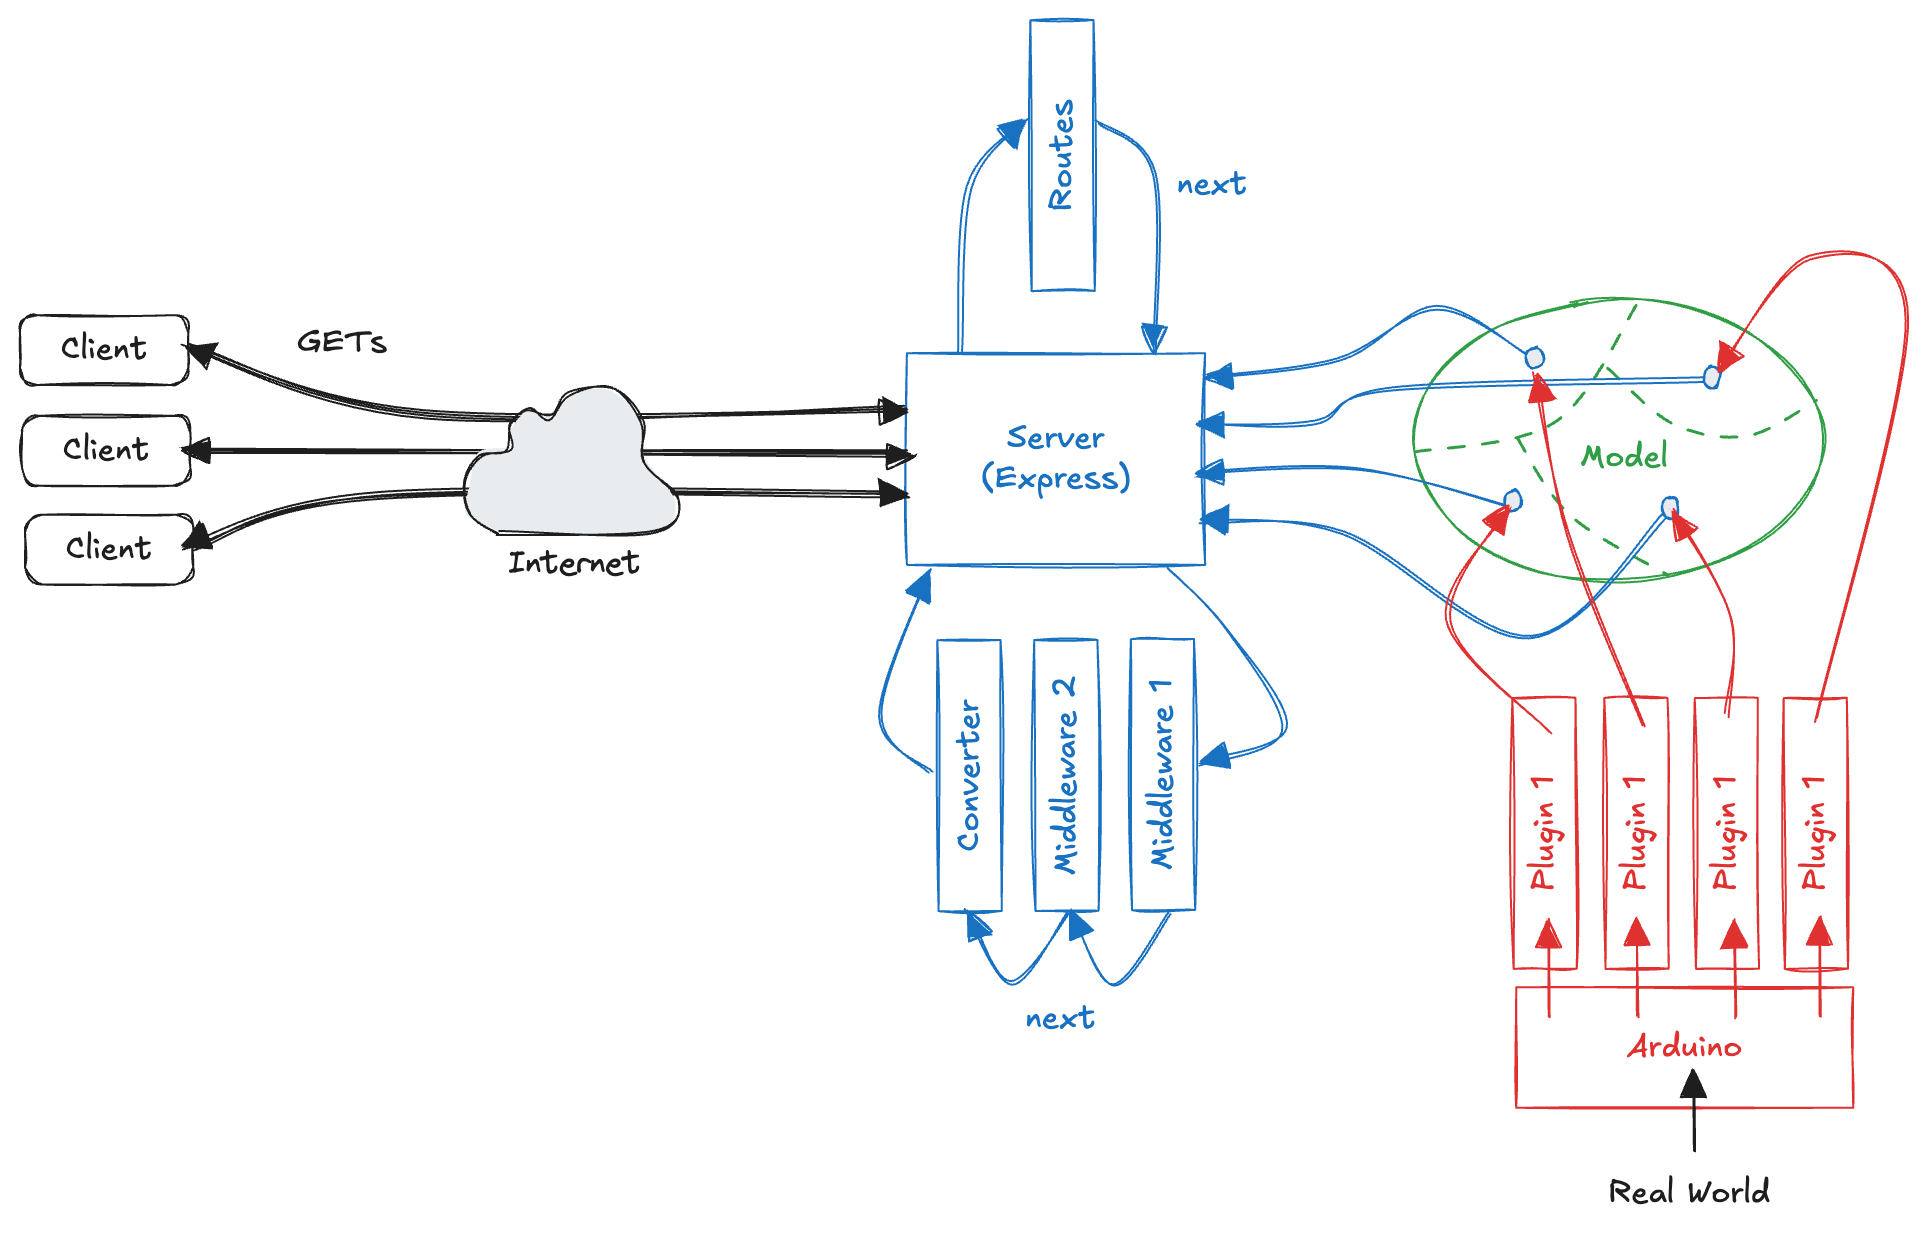

This approach keeps route handlers focused solely on retrieving the right resource, while **the responsibility for formatting the response is entirely delegated to the middleware layer**. This design adheres to the principle of separation of concerns and improves the maintainability and scalability of the codebase.

To implement representation design in practice (see 03.Multiple Representations code), we install the required libraries via NPM ("node-json2html" package to generate readable HTML from JSON and "msgpack5" to encodie into a compact binary format). A custom middleware is then implemented in **middleware/converter.js**:

In [ ]:
// /middlewares/converter.js

// Require the two modules and instantiate a MessagePack encoder
const msgpack = require('msgpack5')();
const json2html = require('node-json2html');

const encode = msgpack.encode;

// In Express, a middleware is usually a function returning a function
module.exports = function() {
  return function (req, res, next) {
    console.info('Representation converter middleware called!');

    // Check if the previous middleware left a result in req.result
    if (req.result) {

      // Read the request header and check if the client requested HTML
      if (req.accepts('html')) {
        console.info('HTML representation selected!');
        // If HTML was requested, use json2html to transform the JSON into simple HTML
        const transform = {'tag': 'div', 'html': '${name} : ${value}'};
        res.send(json2html.transform(req.result, transform));
        return;
      }

      // Read the request header and check if the client requested MessagePack
      if (req.accepts('application/x-msgpack')) {
        console.info('MessagePack representation selected!');
        // Encode the JSON into MessagePack using the encoder
        res.type('application/x-msgpack');
        res.send(encode(req.result));
        return;
      }

      // For all other formats, default to JSON
      console.info('Defaulting to JSON representation!');
      res.send(req.result);
      return;
    
    }

    // If no result was present in req.result, there’s not much you can do, so call the next middleware
    else { next(); }
  }
};

This module inspects each request headers to determine the desired format. It accesses the resource to be returned via a shared property, typically assigned to "req.result", and then serializes it into the appropriate format before sending the response.

To activate this middleware, existing routes (sensors and actuators) must be slightly refactored. Instead of sending the response directly using "res.send(resource)", the resource is assigned to "req.result", and the route handler ends with a call to "next()". This signals Express to pass control to the next middleware, in this case the representation converter:

In [ ]:
// /routes/sensors.js

const express = require('express');

const router = express.Router();
const resources = require('./../resources/model');

router.route('/').get(function (req, res, next) {
  req.result = resources.iot.sensors;
  next();
});

// This route serves the passive infrared sensor
router.route('/pir').get(function (req, res, next) {
  req.result = resources.iot.sensors.pir;
  next();
});

// This routes serve the temperature sensor
router.route('/temperature').get(function (req, res, next) {
  req.result = resources.iot.sensors.temperature;
  next();
});

// This routes serve the light sensor
router.route('/light').get(function (req, res, next) {
  req.result = resources.iot.sensors.light;
  next();
});

module.exports = router;

Finally, the middleware must be registered in the main HTTP server file using "app.use()" to add it into the middleware chain. It should be included **after the route definitions** so it processes only finalized req.result objects:

In [ ]:
// /servers/http.js

const express = require('express');
const actuatorsRoutes = require('./../routes/actuators');
const sensorRoutes = require('./../routes/sensors');
const resources = require('./../resources/model');

// Requires the converter
const converter = require('./../middleware/converter');

// Creates an application with the Express framework
// this wraps an HTTP server
const app = express();

// Binds your routes to the Express application
// bind them to /pi/actuators/... and /pi/sensors/...
app.use('/iot/actuators', actuatorsRoutes);
app.use('/iot/sensors', sensorRoutes);

// Create a default route for /iot
app.get('/iot', function (req, res) {
  res.send('This is the WoT API!')
});

// Add the converter to the chain
// As the converter middleware responds to the client
// make sure you add it last, after app.get('iot') or it
// will simply bypass any other middleware!
app.use(converter());

module.exports = app;

Once this setup is complete, the server becomes capable of responding in three different representations: JSON (application/json), MessagePack (application/x-msgpack), and HTML (text/html). **This enhances both machine-to-machine and human-friendly interactions**, while also supporting **bandwidth-sensitive applications**. The design is modular and extensible, allowing future representations to be added without modifying the route logic.

Supporting multiple representations makes the WoT Proxy more versatile. Clients with different capabilities and constraints can access the same underlying data through a common API, tailored to their specific context. Whether it’s a browser, a low-power sensor node, or a mobile app, each can request the most appropriate format without changing the application logic.

## Interface Design

The interface design of the system focuses on enabling interaction with connected devices through the API, with a gradual evolution from simple data retrieval to **full actuator control**. The initial version of the system supported only basic **GET** operations to retrieve sensor data. While functional, this limited the interaction to read-only operations. To support more dynamic applications, including device control and real-time updates, additional HTTP verbs and mechanisms have been introduced.

### Adding PUT Support

To enable data submission and state modification, the system should be extended to support the **PUT** method. This capability allows clients to send data to the server in a structured format which can be used for tasks such as configuring system parameters or triggering events (see 04.POST support code). In particular, we add the PUT method implementation to enable external clients to update the state of a specific LED actuator by sending a JSON payload with a "value" field:

In [ ]:
// /routes/actuators.js
...

// Callback for a PUT request on an LED
router.route('/leds/:id').put(function(req, res, next) {
  var selectedLed = resources.iot.actuators.leds[req.params.id];
  
  // Update the value of the selected LED in the model
  if(req.body.value == undefined) {
    req.result = { error: "missing value" };  
  }
  else {
    selectedLed.value = req.body.value;
    req.result = selectedLed;  
  }
  next();
});

...

However, updating the model alone is not sufficient, this change must also be **reflected in the physical world**. One option would be to **directly invoke the plugin** to modify the actuator’s value. However, this would make the plugin code **dependent** on the structure of the model, **violating the principle of separation of concerns**. Instead, we should implement a **notification mechanism** that alerts the plugins whenever the model is updated. This way, plugins can autonomously react and update the hardware, without the server code needing to manage how this is done. We can implement this notification mechanism using the **Observer pattern**. The model will maintain a list of observers (in this case, the plugins) and notify them whenever a change occurs. Each plugin will then decide how to handle the update based on its own logic.

### Observer Pattern

The Observer Pattern is a design pattern in which an object (the **subject**) maintains a list of dependents (called **observers**) and notifies them automatically of any state changes. This is useful when multiple components need to stay in sync **without tightly coupling** them. In Node, the [node-observer](https://www.npmjs.com/package/node-observer) package provides a simple way to implement this pattern.

When the API updates the state of an actuator (e.g., turns an LED on or off), we want the hardware-related plugin to be notified automatically and react accordingly, **without embedding hardware logic into the web-related code**.

We need to subscribe the plugin to listen for state changes of the model:

In [ ]:
// /plugins/ledsPlugin.js

const resources = require('./../resources/model');
const observer = require("node-observer");

const model1 = resources.iot.actuators.leds['1'];
const model2 = resources.iot.actuators.leds['2'];

let interval;
const pluginName = "Leds"
let localParams = {'simulate': false, 'frequency': 2000};

exports.start = function (params) {
  localParams = params;
  
  // Observe the model for the LEDs
  observe(model1);
  observe(model2);
  
  if (localParams.simulate) { simulate(); } 
  else { connectHardware(); }
};

exports.stop = function () {
  clearInterval(interval);
  console.info('%s plugin stopped!', pluginName);
};

function observe(what) { 
    observer.subscribe(this, what.name, function(who, data) { switchOnOff(what.name, data); }); 
};

function switchOnOff(name, value) {
  console.info('Change detected by plugin for %s = %s', name, value);
  if (!localParams.simulate) {
    const arduino = require('./../hardware/arduino');
    arduino.send(name, value);
    console.info('Changed value of %s to %s', name, value);
  }
};

function connectHardware() { console.info('Hardware %s actuator started!', pluginName); };

function simulate() {
  interval = setInterval(function () {
    // Switch value on a regular basis
    if (model1.value) { model1.value = false; } 
    else { model1.value = true; }
  }, localParams.frequency);
  console.info('Simulated %s actuator started!', pluginName);
};


Then we need to emit an update when the model changes:

In [ ]:
// /routes/actuators.js

const express = require('express');
const observer = require("node-observer");

const router = express.Router();
const resources = require('./../resources/model');

router.route('/').get(function (req, res, next) {
 req.result = resources.iot.sensors;
 next();
});

router.route('/leds').get(function (req, res, next) {
  req.result = resources.iot.actuators.leds;
  next();
});

router.route('/leds/:pippo').get(function (req, res, next) {
  req.result = resources.iot.actuators.leds[req.params.id];
  next();
});

// Callback for a PUT request on an LED
router.route('/leds/:id').put(function(req, res, next) {
  var selectedLed = resources.iot.actuators.leds[req.params.id];
  // Update the value of the selected LED in the model
  if(req.body.value == undefined) {
    req.result = { error: "missing value" };  
  }
  else {
    selectedLed.value = req.body.value;
    req.result = selectedLed;  

    // Send information to observers
    observer.send(this, selectedLed.name , req.body.value);
  }
  next();
});

module.exports = router;

### Body Parsing Middleware

To fully support verbs like PUT and POST, we needo to handle the payload of incoming HTTP requests. The WoT server supports JSON payloads for actuator control. For example, the state of an LED can be updated by sending the following structure:

In [ ]:
{
  "value": true
}

A **body parser middleware** can been introduced: 

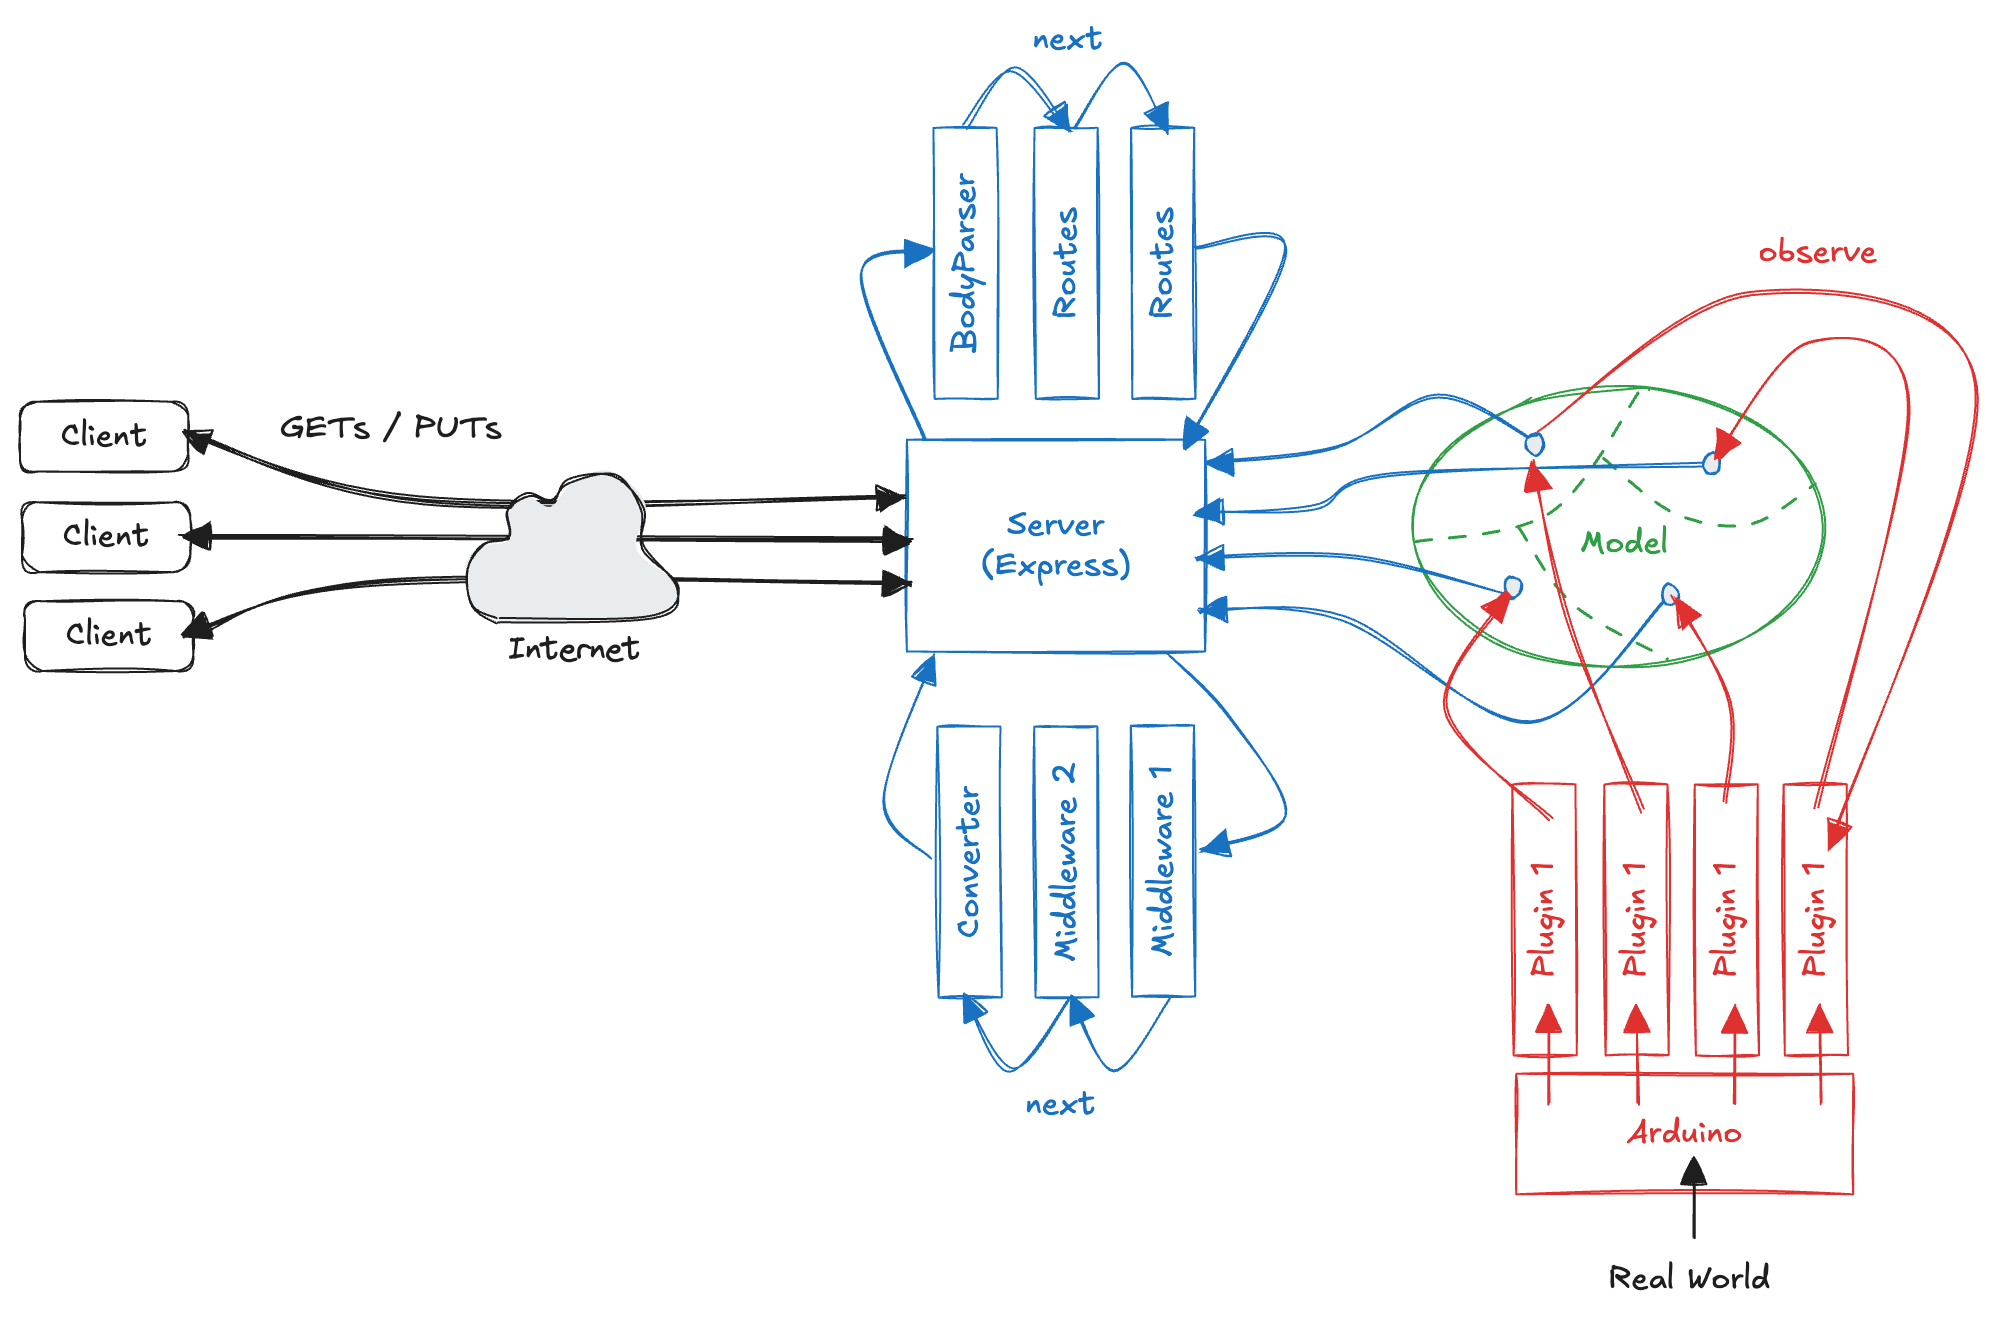

This middleware intercepts the HTTP request at the beginning of the request lifecycle to extract and parse the request body, typically in JSON format:

In [ ]:
const express = require('express');
const actuatorsRoutes = require('./../routes/actuators');
const sensorRoutes = require('./../routes/sensors');
const resources = require('./../resources/model');
const converter = require('./../middleware/converter');

// Requires the body parser
const bodyParser = require('body-parser');

const app = express();

// Add the bodyParser to the chain
// As the bodyParse middleware get information from
// the request useful for other middleware make sure you add it first
app.use(bodyParser.json());

app.use('/iot/actuators', actuatorsRoutes);
app.use('/iot/sensors', sensorRoutes);

app.get('/iot', function (req, res) {
  res.send('This is the WoT API!')
});

app.use(converter());

module.exports = app;

### Bidirectional Serial Communication 

Finally we need to update the Arduino code in order to support **bidirectional interaction**: while the device continues to send sensor readings to the host, it now also listens for incoming characters via the serial port and uses them to control the state of two LEDs, enabling remote actuation directly from the server:

In [ ]:
#include <Wire.h>

const char HEADER = 'H';
int tmp102Address = 0x48;
int led1Pin = 6;
int led2Pin = 7;
int pirPin = 2;
int lightPin = 0;

void setup() {
  Serial.begin(9600);
  
  Wire.begin();
  
  pinMode(led1Pin, OUTPUT);
  pinMode(led2Pin, OUTPUT);
  pinMode(pirPin,  INPUT);
}

void loop() {
  float temperature = getTemperature();
  int motion = getMovement();
  float light = getLight();

  Serial.print(HEADER);
  Serial.print(";");
  Serial.print(temperature);
  Serial.print(";");
  Serial.print(motion);
  Serial.print(";");
  Serial.print(light);
  Serial.println(";");

  if (Serial.available() ) {
    char ch = Serial.read();
    if(ch == '0') setLed(1,0);
    else if(ch == '1') setLed(1,1); 
    else if(ch == '2') setLed(2,0);
    else if(ch == '3') setLed(2,1);
  }
   
  delay(1000); 
}

void setLed(int led, int value) {
  if(led == 1 && value == 1)
    digitalWrite(led1Pin,HIGH);

  if(led == 1 && value == 0)
    digitalWrite(led1Pin,LOW);

  if(led == 2 && value == 1)
    digitalWrite(led2Pin,HIGH);
    
  if(led == 2 && value == 0)
    digitalWrite(led2Pin,LOW);
}

float getLight() {
  return  analogRead(lightPin); 
}

int getMovement() {
  int pirVal = digitalRead(pirPin);
  if(pirVal == LOW) return 1;
  else return 0;
}

float getTemperature() {
  Wire.requestFrom(tmp102Address,2); 
  byte MSB = Wire.read();
  byte LSB = Wire.read();
  int TemperatureSum = ((MSB << 8) | LSB) >> 4; 
  float celsius = TemperatureSum*0.0625;
  return celsius;
}

The arduino.js has to expose the possibility to send commands to the Arduino board. We snippet introduce a **send function**, which is used to transmit data from the application to the connected device. This function ensures proper formatting and delivery of messages, enabling seamless communication between components of the system:

In [ ]:
const serialport = require('serialport');
const readline = require('@serialport/parser-readline')
const portName = '/dev/cu.usbmodem1421';

const values = { temperature:"0", 
                 light: "0", 
                 movement: "0", 
                 send: function(led, data){
                    if(led=="LED 1" && data==false) sp.write("0");
                    if(led=="LED 1" && data==true) sp.write("1");
                    if(led=="LED 2" && data==false) sp.write("2");
                    if(led=="LED 2" && data==true) sp.write("3");
                }
               }

const sp = new serialport(portName, {
    baudRate: 9600,
    dataBits: 8,
    parity: 'none',
    stopBits: 1,
    flowControl: false,
});

const parser = new readline();
sp.pipe(parser);

parser.on('data', function(input) {
    var res = input.split(";");
    
    if(res[0] == 'H') {
      values.temperature = res[1];
      values.movement = res[2];
      values.light = res[3];
    }
});

module.exports = values;

## Real-time data

The current implementation of the WoT Proxy allows clients to retrieve sensor data and control actuators through a RESTful API. However, this model is inherently **polling-based**, meaning that clients must periodically query the server to obtain updated information. This approach can lead to inefficiencies, increased latency, and unnecessary network traffic. To address these limitations, we can introduce **real-time data updates** using WebSockets. This technology enables a persistent connection between the client and server, allowing for **bidirectional communication**. Clients can subscribe to specific events or resources and receive updates as soon as they occur, without needing to poll the server continuously.

### WebSocket Server

The WebSocket server is implemented using the lightweight ws library, chosen for its simplicity and efficiency. A dedicated listener is defined in the **websockets.js** module, which attaches a WebSocket server to the existing Express HTTP server (see 05.WebSocket code):

In [ ]:
// /servers/websocket.js

const WebSocketServer = require('ws').Server;
const resources = require('./../resources/model');
const observer = require("node-observer");

exports.listen = function(server) {

  // Create a WebSockets server by passing it the Express server
  const wss = new WebSocketServer({server: server});
  console.info('WebSocket server started...');
  
  // Triggered after a protocol upgrade when the client connected
  wss.on('connection', function (ws, req) {
    let url = req.url;
    console.info(url);
    
    // Register an observer corresponding to the resource in the protocol upgrade URL
    try {
      observer.subscribe(this, selectResouce(url).name, function(who, data) {
        ws.send(JSON.stringify(selectResouce(url).value), function () {});
      });
    }

    // Intercept errors (e.g., malformed/unsupported URLs)
    catch (e) { console.log('Unable to observe %s resource!', url); console.log(e); };
  });
};

// This function takes a request URL and returns the corresponding resource
function selectResouce(url) {
  let parts = url.split('/');
  parts.shift();
  let result = resources;
  for (let i = 0; i < parts.length; i++) { result = result[parts[i]]; }
  return result;
}

### Observer changes

When a client initiates a WebSocket connection, the server inspects the URL path of the upgrade request to identify the target resource within the shared data model. Using the **observer pattern**, each WebSocket connection subscribes to updates on the corresponding resource. When a change occurs (such as a new temperature reading from a sensor plugin) the WebSocket server pushes the updated value to all connected clients in real time. 

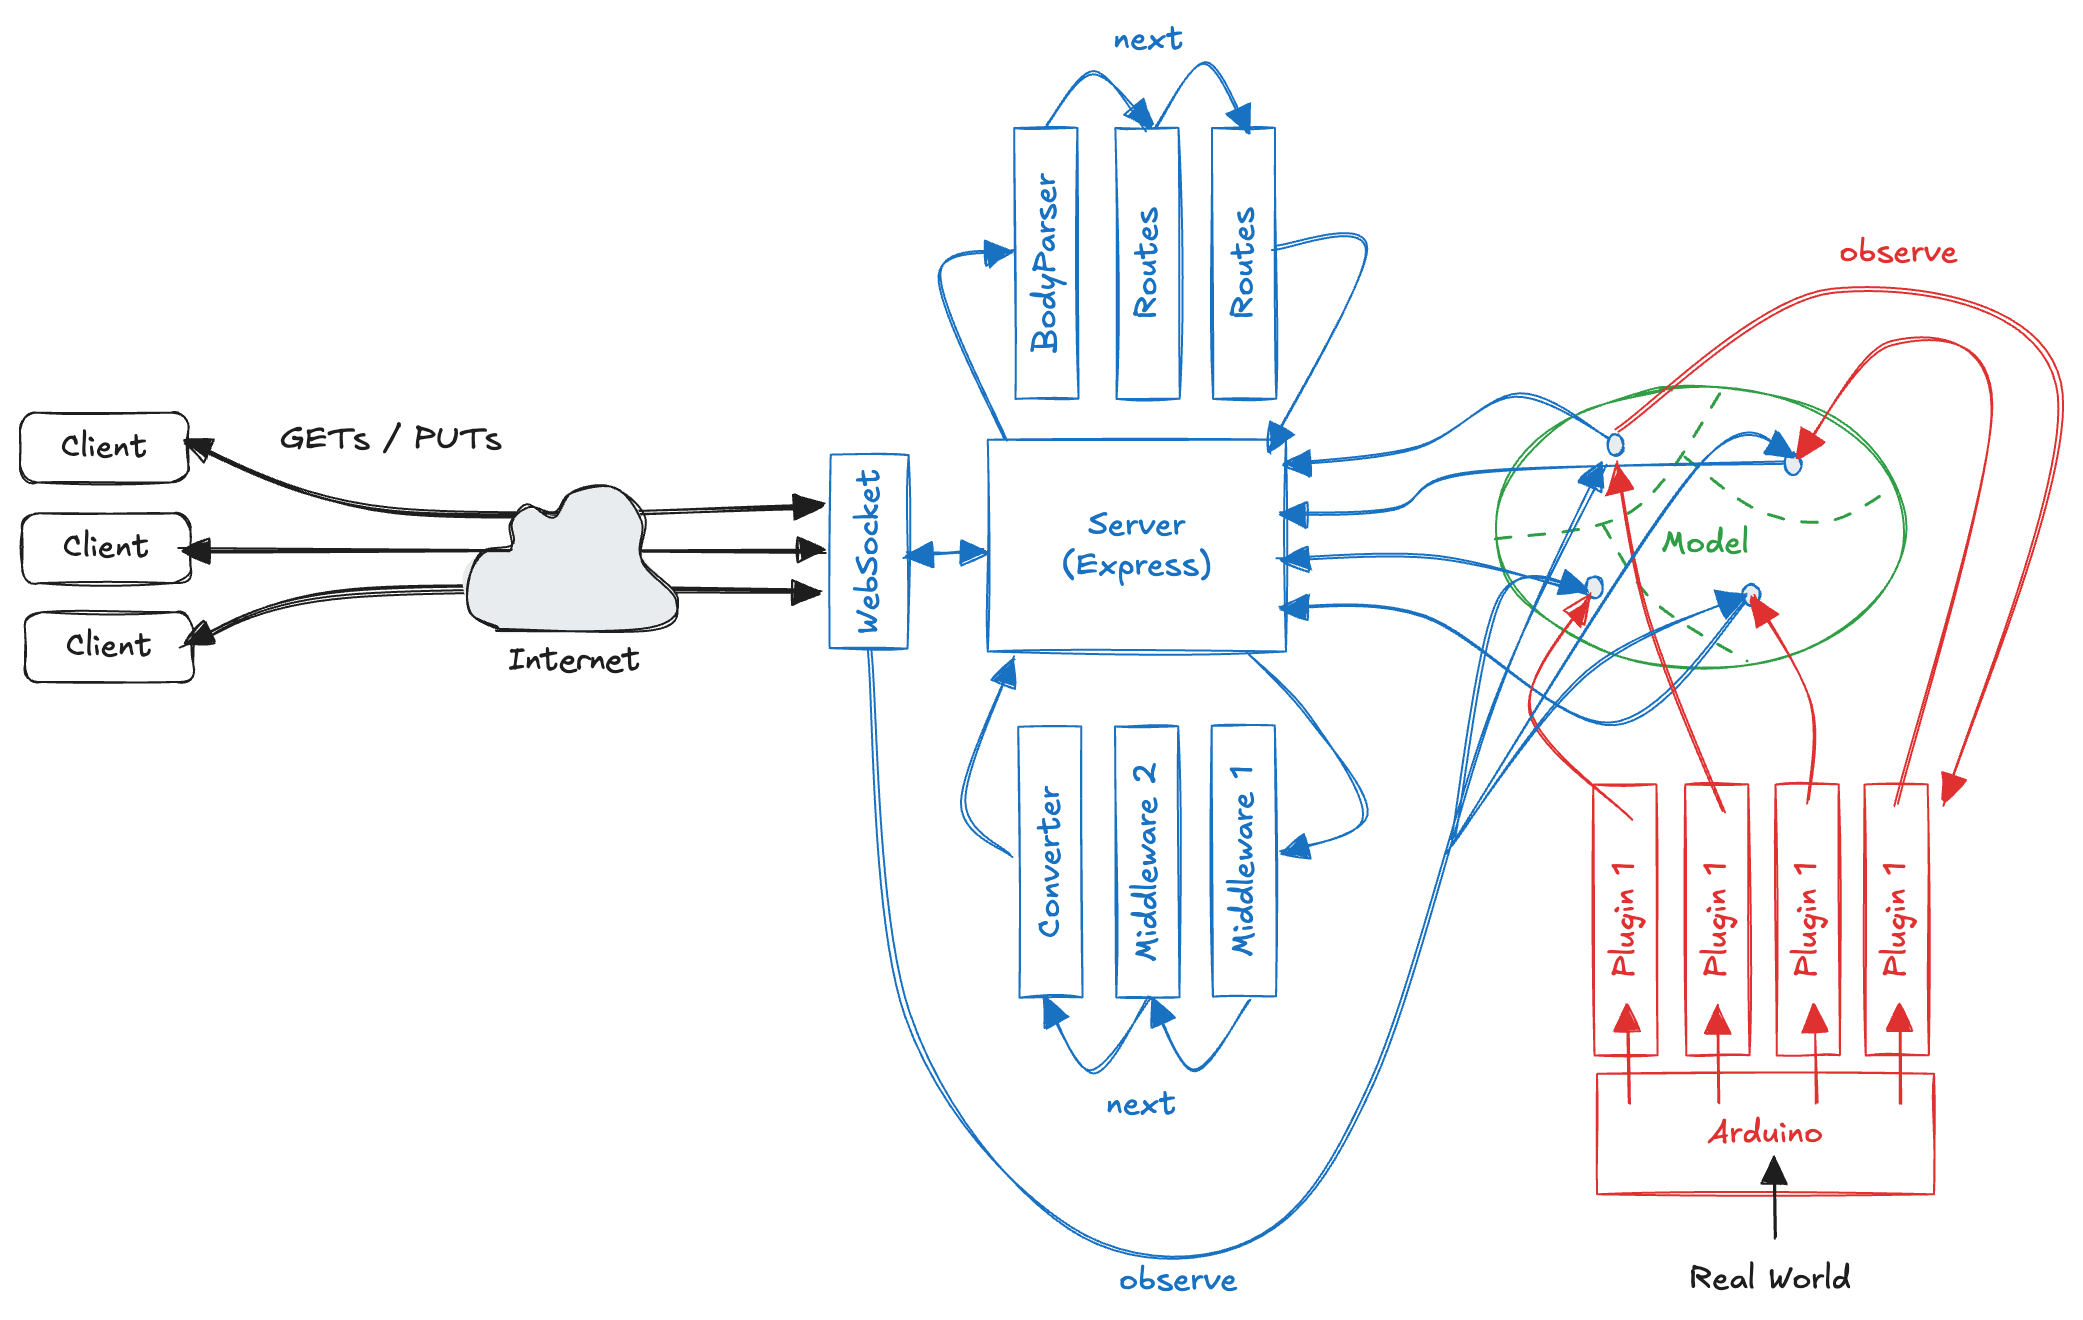

Of course the sensors plugins must be updated to emit the new value whenever a change occurs. For example, the temperature plugin can be modified to emit an event whenever a new value is read from the hardware:

In [ ]:
// /plugins/tempPlugin.js

const resources = require('./../resources/model');
const observer = require("node-observer");

let interval;
const model = resources.iot.sensors.temperature;
const pluginName = resources.iot.sensors.temperature.name;
const unit = resources.iot.sensors.temperature.unit;
let localParams = {'simulate': true, 'frequency': 2000};

// Starts the plugin, should be accessible from other
// files so we export them
exports.start = function (params) {
  localParams = params;
  if (localParams.simulate) { simulate(); } 
  else { connectHardware(); }
};

// Stop the plugin, should be accessible from other
// files so we export them
exports.stop = function () {
  clearInterval(interval);
  console.info('%s plugin stopped!', pluginName);
};

// Require and connect the actual hardware driver and configure it
function connectHardware() {
  var arduino = require('./../hardware/arduino');
  
  interval = setInterval(function () { 
    model.value = arduino.temperature;
    observer.send(this, model.name , model.value); 
  }, localParams.frequency);
  console.info('Hardware %s sensor started!', pluginName);
};

// Allows the plugin to be in simulation mode. This is very useful when developing
// or when you want to test your code on a device with no sensors connected, such as your laptop
function simulate() {
  interval = setInterval(function () { 
    model.value += 1; 
    observer.send(this, model.name , model.value);
    showValue(); 
  }, localParams.frequency);
  console.info('Simulated %s sensor started!', pluginName);
};

function showValue() { console.info('%s value = %s %s', pluginName, model.value, unit); };

### HTTP and WebSocket integration

Finally, to integrate the WebSocket server, the main server script wot-server.js is updated to call the listen function exported from websockets.js, passing the already-running HTTP server. This ensures that WebSocket and HTTP clients share the same port and infrastructure:

In [ ]:
 // Load the http server, the websocekt server and the model
 const httpServer = require('./servers/http');
 const resources = require('./resources/model');
 const wsServer = require('./servers/websockets');

 // Require all the sensor plugins we need
 const ledsPlugin = require('./plugins/ledsPlugin');
 const pirPlugin = require('./plugins/pirPlugin');
 const tempPlugin = require('./plugins/tempPlugin');
 const lightPlugin = require('./plugins/lightPlugin');

 // Start them with a parameter object. Here we start them on a
 // laptop so we activate the simulation function
 ledsPlugin.start({'simulate': true, 'frequency': 1000});
 pirPlugin.start({'simulate': true, 'frequency': 1000});
 tempPlugin.start({'simulate': true, 'frequency': 1000});
 lightPlugin.start({'simulate': true, 'frequency': 1000});

 // Start the HTTP server by invoking listen() on the Express application
 const server = httpServer.listen(resources.iot.port, function () {
    console.info('Your WoT Pi is up and running on port %s', resources.iot.port);
 });
 
 // Start the WebSocket server by passing it the HTTP server
 wsServer.listen(server);

### WebSocket Client

Clients can now open a WebSocket connection (e.g., using /iot/sensors/temperature) and receive updates without polling. A sample HTML client CN demonstrate how the client subscribes and handles incoming updates:

In [ ]:
!-- /public/websocketsClient.js

<!DOCTYPE html>
    <html lang="en">
        <body>
            <script>
                function subscribeToWs(url, msg) {

                    // Create a new WebSocket connection
                    var socket = new WebSocket(url);
                    
                    // Define the event handlers for the WebSocket connection
                    socket.onmessage = function (event) { console.log(event.data); };

                    socket.onerror = function (error) {
                        console.log('An error occurred while trying to connect to a Websocket!');
                        console.log(error);
                    };

                    socket.onopen = function (event) { if (msg) { socket.send(msg); } };
                }

                // Subscribe to the WebSocket server
                subscribeToWs('ws://localhost:8484/iot/sensors/temperature');+
                
            </script>
        </body>
    </html>

This enhancement shifts the WoT Proxy architecture from purely request-response interactions to a hybrid model supporting both synchronous queries and asynchronous notifications, making it suitable for reactive IoT applications such as live dashboards or event-driven automation.

## Inegrate other devices

Th WoT Proxy currently supports a single device, but the architecture is designed to be extensible. We can easily add support for multiple devices by creating additional resource models and plugins. Each device can have its own set of sensors and actuators, and the WoT Proxy can expose them under different paths in the API. Moreover, devices can be connected to the proxy using different protocols, depending on their capabilities. This flexibility allows the WoT Proxy to act as a **universal gateway** for various devices, regardless of their underlying technology.

Many real-world battery-powered devices and resource-constrained microcontrollers cannot connect over Wi-Fi or Ethernet and instead rely on **low-power communication protocols** such as **Bluetooth Low Energy (BLE)** or **ZigBee**. 

In that case, the procy can act as a gateway, and speaks to the constrained device using a protocol it understands (e.g., **Constrained Application Protocol (CoAP)**), and translates the data and commands into the RESTful API that clients can consume using HTTP or WebSockets. This pattern provides a number of benefits. It decouples the physical limitations of the device from the requirements of web protocols, making the integration scalable and robust:

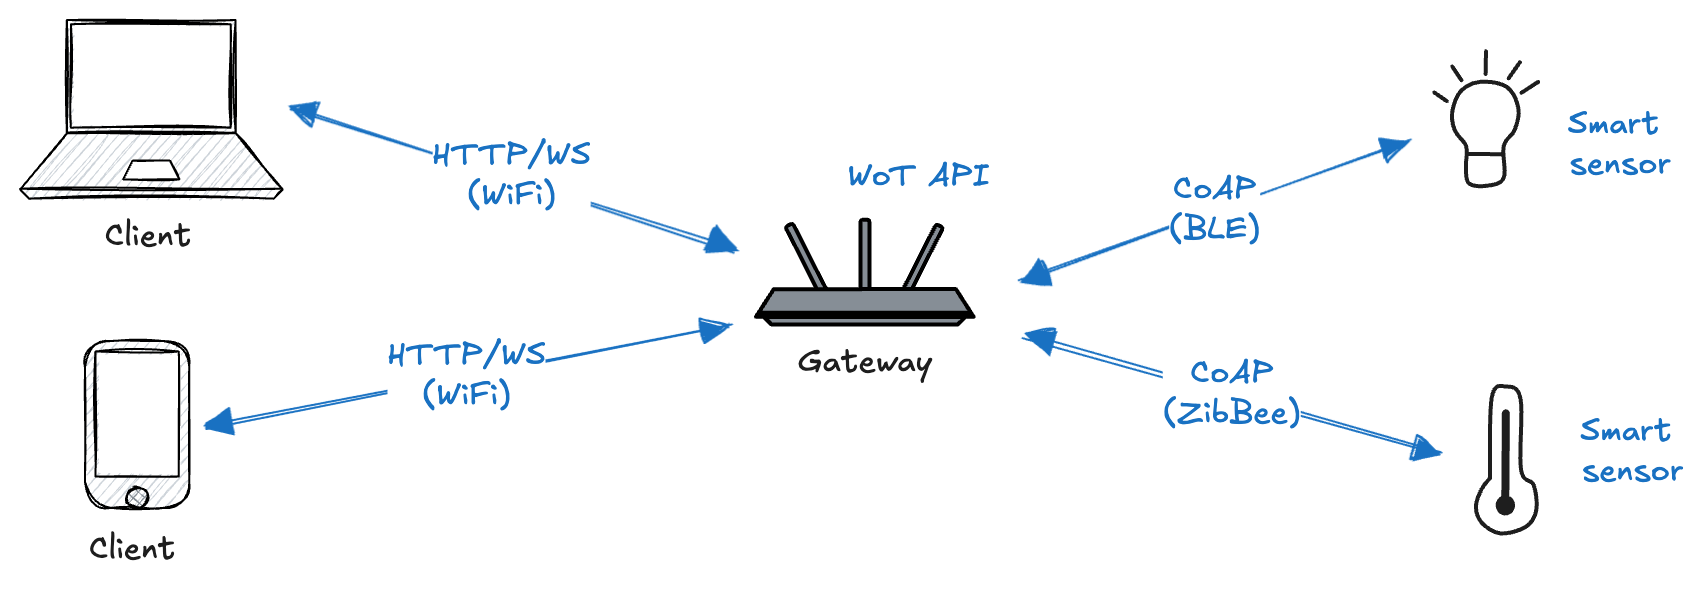

In addition to protocol translation, the procy can perform additional roles. It can enrich security by adding authentication or encryption layers that the device cannot handle. It can buffer data, acting as temporary storage in case of intermittent connectivity, a key feature of what is often called **fog computing**. It can also expose semantic metadata for devices that lack the capability to describe themselves, enabling automatic discovery and integration.

In the WoT Proxy architecture, the gateway is responsible for managing these low-level interactions, abstracting them behind standard REST resources. From the perspective of a web client, there is no difference between interacting with a natively web-enabled Thing and one that is bridged through a gateway. The uniformity of the API and the abstraction of protocol details are what enable true interoperability across the heterogeneous landscape of IoT devices.

### CoAP device

The [**Constrained Application Protocol (CoAP)**](https://datatracker.ietf.org/doc/html/rfc7252) is a lightweight, REST-based protocol specifically designed for resource-constrained devices and low-power communication scenarios. It operates over **UDP** instead of TCP and is ideally suited for device-to-device communication across low-power wireless networks such as ZigBee. Unlike HTTP, it has a **minimal footprint**, making it feasible to implement even on microcontrollers like the Arduino Uno.  To experiment with CoAP, we implement a simple CoAP device using Node (see 06.CoAP code) to simulate a CO2 sensor. The device exposes a single resource, /co2, which returns the current CO2 level in parts per million (ppm). The CoAP server is implemented using the [coap](https://www.npmjs.com/package/coap) module:

In [ ]:
// /devices/coap.js

// Require the Node.js CoAP module you installed
const coap = require('coap');
const port = 5683;

// Create a CoAP server and bind it to the callback function
coap.createServer(function (req, res) {

  console.info('CoAP device got a request for %s', req.url);
  
  // We only serve JSON, so we reply with a 4.06 (= HTTP 406: Not acceptable)
  if (req.headers['Accept'] != 'application/json') {
    res.code = '4.06';
    return res.end();
  }
  
  // Handle the different resources requested
  switch (req.url) {
    // This is a simulated CO2 resource; generate a random value for it and respond
    case "/co2":
      respond(res, {'co2': Math.floor(Math.random() * 1000)});
      break;
    default:
      respond(res);
  }
}).listen(port, function () {
  // Start the CoAP server on port 5683 (CoAP’s default port)
  console.log("CoAP server started on port %s", port)
});

// Send the JSON content back or reply with a 4.04 (= HTTP 404: Not found)
function respond(res, content) {
  if (content) {
    res.setOption('Content-Format', 'application/json');
    res.code = '2.05';
    res.end(JSON.stringify(content));
  } else {
    res.code = '4.04';
    res.end();
  }
};

This demonstrates how to run a CoAP server on a resource-limited device, simulating such behavior using Node.js.

### Gateway

To make CoAP device accessible from standard web clients, we can proxied it through our HTTP-capable WoT Proxy, following the **Gateway Integration Pattern**. The resource model is extended in resources.json to describe the new CoAP device: 

In [ ]:
{
  "iot": {
    "name": "MyWoT",
    "description": "A simple WoT API",
    "port": 8484,
    "sensors": {
      "temperature": {
        "name": "Temperature Sensor",
        "description": "An ambient temperature sensor.",
        "unit": "celsius",
        "value": 0
      },
      "light": {
        "name": "Light Sensor",
        "description": "An ambient light sensor.",
        "unit": "%",
        "value": 0
      },
      "pir": {
        "name": "Passive Infrared",
        "description": "A passive infrared sensor. When 'true' someone is present.",
        "value": true
      },
      "co2": {
        "name": "Co2 Sensor",
        "description": "An ambient CO2 sensor",
        "unit": "ppm",
        "value": 0
      }
    },
    "actuators": {
      "leds": {
        "1": {
          "name": "LED 1",
          "value": false
        },
        "2": {
          "name": "LED 2",
          "value": false
        }
      }
    }
  }
}

Then, a dedicated plugin (coapPlugin.js) is implemented to communicate with the CoAP endpoint and update the shared data model accordingly. This plugin typically uses the coap module to issue CoAP requests to the target device and parse the responses:

In [ ]:
// /plugins/coapPlugin.js

const resources = require('./../resources/model');

const model = resources.iot.sensors.co2;
const pluginName = resources.iot.sensors.co2.name;
const unit = resources.iot.sensors.co2.unit;

let interval, pollInterval;
let localParams = {'simulate': false, 'frequency': 5000};

function connectHardware() {
  
  // Require the CoAP and BL library, a Buffer helper
  const coap = require('coap');
  const bl = require('bl');

  // Create a sensor object and give it a read function
  var sensor = {
    // The read function wraps a coap over UDP request with the enclosed parameters; 
    // replace localhost with the IP of the machine you’re simulating the CoAP 
    // device from (e.g., your laptop)
    read: function () {
      coap
        .request({
          host: 'localhost',
          port: 5683,
          pathname: '/co2',
          options: {'Accept': 'application/json'}
        })
        // When CoAP device sends the result, the on response event is triggered
        .on('response', function (res) {
          console.info('CoAP response code', res.code);
          if (res.code !== '2.05')
            console.log("Error while contacting CoAP service: %s", res.code);
          // Fetch the results and update the model  
          res.pipe(bl(function (err, data) {
            var json = JSON.parse(data);
            model.value = json.co2;
            showValue();
          }));
        })
        .end();
    }
  };
  
  // Poll the CoAP device for new CO2 readings on a regular basis
  pollInterval = setInterval(function () {
    sensor.read();
  }, localParams.frequency);
};

exports.start = function (params, app) {
  localParams = params;

  if (params.simulate) {
    simulate();
  } else {
    connectHardware();
  }
};

exports.stop = function () {
  if (params.simulate) {
    clearInterval(interval);
  } else {
    clearInterval(pollInterval);
  }
  console.info('%s plugin stopped!', pluginName);
};

function simulate() {
  interval = setInterval(function () {
    model.value = Math.floor(Math.random() * 1000);
    showValue();
  }, localParams.frequency);
  console.info('Simulated %s sensor started!', pluginName);
};

function showValue() {
  console.info('CO2 Level: %s ppm', model.value);
};

Next, the server’s route definitions in sensors.js are updated to include endpoints that expose the CoAP device data over HTTP:

In [ ]:
// /routes/sensors.js

var express = require('express');

var router = express.Router();
var resources = require('./../resources/model');

router.route('/').get(function (req, res, next) {
  req.result = resources.iot.sensors;
  next();
});

router.route('/pir').get(function (req, res, next) {
  req.result = resources.iot.sensors.pir;
  next();
});

router.route('/temperature').get(function (req, res, next) {
  req.result = resources.iot.sensors.temperature;
  next();
});

router.route('/light').get(function (req, res, next) {
  req.result = resources.iot.sensors.light;
  next();
});

// This routes serve the co2 sensor
router.route('/co2').get(function (req, res, next) {
  req.result = resources.iot.sensors.co2;
  next();
});

module.exports = router;

Finally, the new plugin is loaded and started from the main entry point wot-server.js, just like the other hardware plugins:

In [ ]:
// /wot-server.js

// Load the http server, the websocekt server and the model
const httpServer = require('./servers/http');
const resources = require('./resources/model');
const wsServer = require('./servers/websockets');

// Require all the sensor plugins we need
const ledsPlugin = require('./plugins/ledsPlugin');
const pirPlugin = require('./plugins/pirPlugin');
const tempPlugin = require('./plugins/tempPlugin');
const lightPlugin = require('./plugins/lightPlugin');
const coapPlugin = require('./plugins/coapPlugin');

// Start them with a parameter object. Here we start them on a
// laptop so we activate the simulation function
ledsPlugin.start({'simulate': true, 'frequency': 1000});
pirPlugin.start({'simulate': true, 'frequency': 1000}); 
tempPlugin.start({'simulate': true, 'frequency': 1000});
lightPlugin.start({'simulate': true, 'frequency': 1000});
coapPlugin.start({'simulate': false, 'frequency': 1000});

const server = httpServer.listen(resources.iot.port, function () {
    console.info('Your WoT Pi is up and running on port %s', resources.iot.port);
});
 
// Websockets server
wsServer.listen(server);

Once this setup is complete, the CoAP device becomes accessible through the WoT Proxy via HTTP, making it transparent to clients whether the underlying device uses HTTP, CoAP, or any other protocol. This abstraction not only simplifies client development but also enables heterogeneous devices to be integrated into the same web-based application logic, reinforcing the WoT Proxy’s goal of unifying the Web of Things under a consistent API.

## Test-Driven Development

As our applications grow, so does the need to ensure that each part works as intended. One of the most reliable strategies for writing robust and maintainable code is **Test-Driven Development**, or **TDD**. TDD is not just about catching bugs, it's a disciplined workflow that encourages better design and more confidence in your codebase. It is a methodology where tests are written **before** the code they’re meant to verify. The process usually follows three simple steps:

1. **Write a test** for a specific behavior or feature.
2. **Run the test** and watch it fail (since the feature hasn’t been implemented yet).
3. **Write the minimal code** necessary to make the test pass.
4. **Refactor** the code while ensuring the test still passes.
5. Repeat.

This approach helps us think more clearly about the behavior we expect from our code and ensures that each new feature or change is verifiable and isolated.

Beyond correctness, unit tests offer secondary benefits. They act as living documentation, help prevent regressions during future code changes, and promote modular, decoupled code that is easier to maintain and extend.

### Using assert

Node.js comes with a built-in module called assert, which allows developers to perform simple tests by checking that values are equal, defined, or follow certain conditions. If an assertion fails, an exception is thrown — which signals that the test did not pass. Here’s a basic example of using assert:

In [ ]:
const assert = require('assert');

assert.strictEqual(1 + 1, 2); // Passes
assert.strictEqual('hello'.toUpperCase(), 'HELLO'); // Passes
assert.strictEqual([1, 2].length, 3); // Fails and throws an error

While assert is great for quick and simple testing, real-world projects benefit from more powerful testing frameworks to provide a more structured test suites, better reporting, and advanced mocking capabilities. 

### Unit tests

Unit testing is the practice of writing code that **validates the behavior of individual units** of functionality in a program, typically a single function or module. These tests are written by developers and are meant to verify that a specific portion of code performs as expected in a variety of scenarios. The idea is to **isolate the smallest testable parts** of an application and ensure that each performs correctly, both in normal and edge cases.

A famous quote by Edsger Dijkstra reminds us of a core limitation of testing: "Program testing can be used to show the presence of bugs, but never to show their absence". 

Historically, developers often performed unit tests **manually**, by running the code and checking outputs. However, this ad-hoc approach is not structured, not repeatable, and not scalable. Without **automation**, tests are often skipped, poorly documented, or inconsistently applied across the codebase.

To illustrate the concept, consider a simple function:

In [ ]:
function sum(numbers) {
  let sum = 0;
  for (let i = 0; i < numbers.length; i++) sum += numbers[i];
  return sum;
}

A corresponding unit test might look like this:

In [ ]:
function testSum() {
  if (sum([1, 2]) !== 3) throw new Error("1+2 != 3");
  if (sum([-2]) !== -2) throw new Error("-2 != -2");
  if (sum([]) !== 0) throw new Error("0 != 0");
}

This test suite checks whether the function correctly sums an array of numbers under different conditions. If any check fails, an error is thrown, signaling that something is wrong with the implementation.

There are a few widely accepted rules of thumb when it comes to unit testing. **All significant logic in the codebase should be covered**. This means that all objects should be tested, and non-trivial methods (those performing more than simple assignments) should be covered by dedicated tests. **Routine code like simple getters/setters or private helper methods may be omitted** unless they contain meaningful logic. **Before pushing code changes into the version control system, all unit tests should pass**, ensuring that no regressions are introduced.

The advantages of unit testing are substantial. It leads to a **measurable reduction in the number of bugs**, as many errors are caught during development before they ever reach QA or production. It also promotes **better software design**, since writing testable code often leads to cleaner, more modular architecture. Additionally, **tests serve as live documentation**, illustrating how components are intended to behave and interact. From a business perspective, unit testing **reduces the cost of changes and refactoring**, providing developers with the confidence to evolve codebases safely.

An important concept in unit testing is **mocking**. Often, the unit under test depends on other complex components such as databases, APIs, or other services. To **keep the unit test isolated and fast**, these dependencies are replaced with mocks (**fake implementations that simulate the behavior of real objects**=. Mocks allow the test to focus solely on the logic of the unit itself, without being affected by the state or availability of external systems.

Modern development heavily relies on testing frameworks to write, run, and manage unit tests efficiently. Popular tools include **QUnit**, **Jasmine**, and **Mocha**. These frameworks offer a structured syntax, support for assertions, setup and teardown hooks, and integration with CI/CD pipelines.

Altogether, unit testing forms the foundation of modern software quality assurance. By enforcing discipline early in the development lifecycle, it leads to more robust, maintainable, and resilient systems.

### Mocha

**Mocha** is a widely used JavaScript testing framework designed for writing and executing unit tests in Node.js applications. It provides a **simple and expressive syntax** for defining and organizing test suites and individual test cases, making it easier to ensure code correctness throughout development.

A basic Mocha test follows a structured format that uses three core components: **describe**, **it**, and **assert**. In the example below, we test two basic properties of a string (see 07.Testing Examples/01.Basic code):

In [ ]:
let assert = require('assert');

describe('Basic Mocha String Test', function () {
  it('should return number of characters in a string', function () {
    assert.equal("Hello".length, 5);
  });

  it('should return first character of the string', function () {
    assert.equal("Hello".charAt(0), 'H');
  });
});

The function **describe()** is used to **group related tests under a common name**, providing semantic structure to the test suite. It takes two parameters: a string describing the functionality under test, and a function that contains one or more test cases.

Inside the describe block, **each it() function defines an individual test case**. The first argument is a human-readable description of what the test verifies, and the second is a function containing the test logic.

Assertions can be written using the assert module. The function **assert.equal(actual, expected)** checks whether the actual result matches the expected one. If the values differ, the test fails and Mocha will report the failure.

To use Mocha in a Node.js project, we need to install it as a **development dependency** (a package that is only needed during the development phase, but not during production):

In [ ]:
npm install --save-dev mocha

These dependencies are listed under the "**devDependencies**" section in the package.json file:

In [ ]:
{
  "name": "01",
  "version": "1.0.0",
  "description": "",
  "main": "index.js",
  "scripts": {
    "test": "mocha"
  },
  "author": "",
  "license": "ISC",
  "devDependencies": {
    "mocha": "5.0.1"
  }
}

Notice the **test script** section, which allows us to run the tests using the command "npm test". This command will execute Mocha and run all test files in the project:

In [ ]:
npm test

By convention, Mocha looks for test files in the **test/** directory, so we should place all our test files there (for example, test/test.js). Each test file should use Mocha’s syntax with describe, it, and assertions.

Mocha will execute tests, displaying a **summary of passed and failed tests** in the terminal. This setup allows us to **continuously verify that your code behaves as expected during development**. For example, the floowing output shows that one test passed and one failed: 

In [ ]:
Basic Mocha String Test
    1) should return number of charachters in a string
    ✓ should return first charachter of the string

  1 passing (2ms)
  1 failing

  1) Basic Mocha String Test
       should return number of charachters in a string:

      AssertionError [ERR_ASSERTION]: 5 == 6
      + expected - actual

      -5
      +6
      
      at Context.<anonymous> (test/test.js:4:16)
      at process.processImmediate (node:internal/timers:485:21)

Several information is provided in the output. In the example, we can see that he failure is due to an incorrect expected value in the test case that checks the length of the string "Hello". The test expected 6 characters, but the actual result was 5, leading to an assertion error. This demonstrates how Mocha clearly reports the status of each test, helping developers quickly identify and correct issues in their code. This setup allows us to **continuously verify that your code behaves as expected during development**.

### Function Testing

The key idea is that every function is responsible for a clearly defined operation. To verify its correctness, a test must call that function with the necessary input values and compare the actual result with the expected one using assertions.

As a practical example, consider the function "isValidUserId", which checks whether a given user ID is valid. This function takes two parameters: a user ID and a list of valid users. It returns true if the user ID is found in the list, and false otherwise (see 07.Testing Examples/02.TestingFunction code):

In [ ]:
exports.isValidUserId =  function(userList, user) {
  if(!userList) return false;
  return userList.indexOf(user) >= 0;
}

The test file should be placed in the test/ directory:

In [ ]:
const assert = require('assert');
const loginController =  require('../../controllers/login.controller');

describe('LoginController', function () {
  describe('isValidUserId', function(){
    it('should return true if valid user id', function(){
      const isValid = loginController.isValidUserId(['abc123','xyz321'], 'abc123')
      assert.equal(isValid, true);
    });
    it('should return false if invalid user id', function(){
      const isValid = loginController.isValidUserId(['abc123','xyz321'],'abc1234')
      assert.equal(isValid, false);
    });
    it('should return false if missing user id', function(){
      const isValid = loginController.isValidUserId(['abc123','xyz321'], null)
      assert.equal(isValid, false);
    });
    it('should return false if missing user list', function(){
      const isValid = loginController.isValidUserId(null, 'xy32')
      assert.equal(isValid, false);
    });
  });
});

Each test case provides different input scenarios (valid ID, invalid ID, null ID and missing user list) and uses assertions to confirm whether the function behaves as expected in each case. This method demonstrates a clear testing pattern: **define the input, call the function, and use assertions to verify the output**. This approach helps ensure correctness, catch regressions, and improve overall software reliability.

### Testing asynchronous function

When dealing with **asynchronous code** (such as functions that perform delayed operations or interact with external resources) it is essential to inform Mocha when the test is complete. Otherwise, Mocha might finish the test prematurely, before the callback is invoked. In the following example (see 07.Testing Examples/03.AsyncCallback), the function isValidUserIdAsync simulates an asynchronous check by calling a callback inside a setTimeout:

In [ ]:
exports.isValidUserIdAsync = function(userList, user, callback) {
  setTimeout(function(){ callback(userList.indexOf(user) >= 0) }, 5);
}

To test this function properly in Mocha, the it block must accept a done parameter and call it only after the asynchronous operation finishes. This signals to Mocha that the test is complete:

In [ ]:
const assert = require('assert');
const loginController =  require('../../controllers/login.controller');

describe('LoginController', function () {
  describe('isValidUserIdAsync', function(){
    it('should return true if valid user id', function(done){
        loginController.isValidUserIdAsync(['abc123','xyz321'], 'abc123', function(isValid){
            assert.equal(isValid, true);
            // Notifies Mocha that the async test is finished
            done(); 
        });
    });
  });
});

### Hooks

Hooks are special functions that allow **to run setup and teardown logic before or after tests**. They are particularly useful when we need to prepare a consistent environment before each test runs, or clean up afterward to avoid interference between tests. In particular, **beforeEach()** is used to run code before each test case, typically to set up a known state, mock data, or initialize components. Conversely, **afterEach()** runs after each test case and is commonly used to clean up resources, reset state, or clear side effects that occurred during the test. For example, consider the following code to be tested (see 07.Testing Examples/04.Hooks code):

In [ ]:
let userList;

exports.loadUserList = function(users) {
  userList = users;
}

exports.isValidUserId = function(user) {
  return userList.indexOf(user) >= 0;
}

exports.isValidUserIdAsync = function(user, callback) {
  setTimeout(function(){ callback(userList.indexOf(user) >= 0) }, 1);
}

We can use beforeEach() to guarantee that the users array is freshly initialized for every test. afterEach ensures that the state is cleared after each run. This pattern improves code clarity, avoids duplication, and enhances test reliability:

In [ ]:
const assert = require('assert');
const loginController =  require('../../controllers/login.controller');

beforeEach('Setting up the userList', function(){
  console.log('beforeEach');
  loginController.loadUserList(['abc123','xyz321']);
});

describe('LoginController', function () {
    describe('isValidUserId', function(){
    
        it('should return true if valid user id', function(){
            const isValid = loginController.isValidUserId('abc123')
            assert.equal(isValid, true);
        });
    
        it('should return false if invalid user id', function(){
            const isValid = loginController.isValidUserId('abc1234')
            assert.equal(isValid, false);
        });
    });

    describe('isValidUserIdAsync', function(){
        it('should return true if valid user id', function(done){
            loginController.isValidUserIdAsync('abc123',
            function(isValid){ assert.equal(isValid, true); done(); });
        });
    });
});

### Chai 

Mocha is often used alongside other libraries, such as **Chai** for **more expressive assertions** or Sinon for mocking. Combined, these tools provide a powerful and flexible environment for building confidence in your code through systematic and automated testing. As an example, we can apply the **Chai assertion library** that provides a more natural and expressive syntax for writing test validations. It can be seamlessly integrated with any JavaScript testing framework such as Mocha and is widely appreciated for its readable, human-friendly style. Chai supports multiple assertion styles:
- **assert**: similar to Node’s built-in assertion library
- **expect**: fluent, chainable assertions (expect(value).to.equal(expected))
- **should**: extends object prototypes for chainable assertions (value.should.equal(expected))

For example, the test for the previous login controller can be rewritten using Chai’s expect style:

In [ ]:
const assert = require('assert');
const loginController =  require('../../controllers/login.controller');

const expect = require('chai').expect;
const should = require('chai').should();

beforeEach('Setting up the userList', function(){
  loginController.loadUserList(['abc123','xyz321']);
});

describe('LoginController', function () {
    describe('isValidUserId', function(){
    
        it('should return true if valid user id', function(){
            const isValid = loginController.isValidUserId('abc123')
            //assert.equal(isValid, true);
            expect(isValid).to.be.true;
        });
    
        it('should return false if invalid user id', function(){
            const isValid = loginController.isValidUserId('abc1234')
            //assert.equal(isValid, false);
            isValid.should.equal(false);
        });
  });

  describe('isValidUserIdAsync', function(){
    
        it('should return true if valid user id', function(done){
            loginController.isValidUserIdAsync('abc123',
            function(isValid){
                //assert.equal(isValid, true);
                isValid.should.equal(true);
                done();
            });
        });
    });
});

The test code demonstrates how to use both **expect** and **should** styles:

In [ ]:
expect(isValid).to.be.true;
isValid.should.equal(false);

The tests are more readable than traditional assert syntax and clearly describe the intent. Another example is shown in the following test (see 07.Testing Examples/06.ChaiStyle code):  

In [ ]:
const should = require('chai').should();

describe('Object Test', function(){
  it('should have property name', function(){
    const car = { name:'Compass', Maker:'Jeep' }
    car.should.have.property('name');
  });

  it('should have property name with value Compass', function(){
    const car = { name:'Compass', Maker:'Jeep' }
    car.should.have.property('name').equal('Compass');
  });

  it('should compare objects', function(){
    const car = {name:'Compass', Maker:'Jeep'}
    const car1 = {name:'Compass', Maker:'Jeep'}
    car.should.deep.equal(car1);
  });
});

Here, the should interface is used to validate object properties:

In [ ]:
car.should.have.property('name').equal('Compass');

It also includes deep equality checks for object comparisons:

In [ ]:
car.should.deep.equal(car1);

This makes the test output more informative and aligns closely with how developers reason about data structures. In conclusion, Chai enriches the developer experience by transforming traditional assertions into self-descriptive, fluent expressions. Whether we’re writing simple unit tests or advanced asynchronous checks, Chai helps ensure our tests communicate exactly what they are validating.

### Bug cost

In software development, one of the most critical factors influencing project success is how early bugs are detected and fixed. **The cost of fixing a bug increases exponentially the later it is discovered** in the software lifecycle:

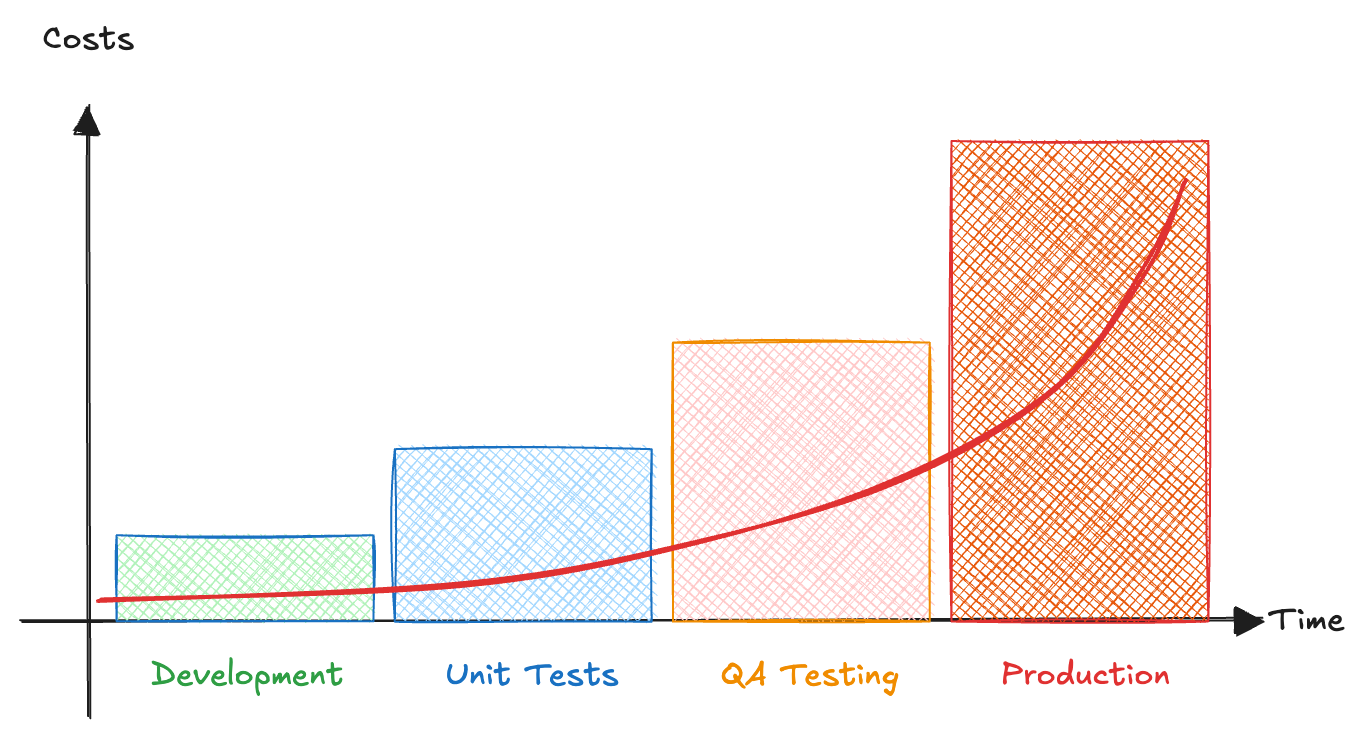

During the **development stage**, bugs can typically be fixed by the developer who wrote the code, with full access to the logic, context, and dependencies. At this point, code is still fresh in memory, tests are small and fast, and no user-facing consequences are involved. A correction here may take just minutes.

When bugs are caught in the **unit testing phase**, the cost is slightly higher. Although the code is still under the developer’s control, more structured effort is required to write tests, interpret failures, and ensure the fix maintains existing functionality. Nevertheless, the investment in unit testing at this stage still yields high returns by avoiding downstream issues.

As we move into **QA testing**, bugs become more expensive. QA engineers must report issues, developers must analyze logs or reproduce behaviors from less direct feedback, and fixes must go through review, integration, and retesting cycles. Coordination overhead and communication delays add to the cost.

Finally, **bugs discovered in production represent the most critical and costly failures**. At this point, the issue may be affecting real users, causing system outages, data loss, or security breaches. Fixing these errors requires emergency patches, hotfix deployments, and in some cases, legal or reputational damage control. Moreover, debugging in a production environment is often harder due to limited observability and increased pressure to resolve the problem quickly.

This escalating cost highlights **the importance of early error detection** through practices such as automated testing, code reviews, static analysis, and continuous integration. Investing in these techniques up front minimizes long-term risk and dramatically reduces the total cost of maintenance and bug fixing throughout the project lifecycle.

### Testing the WoT Proxy

Testing the WoT Proxy API is a critical step to ensure that all RESTful endpoints behave as expected. This involves writing test scripts for routes such as /temperature or /measurement, validating both structure and response content (see 08. Test WoT Proxy code).

To begin, a **test/ folder** should be added to our project structure. Inside it, we can create files like temperature-test.js to test the temperature sensor route:

In [ ]:
const server = require('../servers/http');
const chai = require('chai');
const chaiHttp = require('chai-http');
const should = chai.should();

chai.use(chaiHttp);

// Temperature /GET route
describe('/GET temperature', () => {
    it('it should GET the temperature', async () => {
        const res = await chai.request(server).get('/iot/sensors/temperature');
        res.should.have.status(404);
        res.body.should.be.a('object');
    });
});

These files typically use Mocha as the test runner and Chai (with **chai-http**) to **simulate HTTP requests**. In package.json, wey add a test script entry:

In [ ]:
  "scripts": {
    "prod": "node ./wot-server.js -prod",
    "test": "nyc mocha"
  },

In addition to writing tests, it is essential to track **test coverage**, a metric that quantifies how much of our codebase is exercised when the tests run. Higher coverage generally correlates with fewer undetected bugs. Coverage can be assessed using tools like **nyc**, which provide metrics such as:
- the percentage of executed code statements
- the percentage of covered functions or branches

We can install the tool via:

In [ ]:
npm install -g nyc 

Once configured, we can run the tests using nyc

In [ ]:
nyc npm test

This will generate a **detailed report** showing which parts of the code were covered and which were not, helping you identify testing gaps. Through this structured approach, the WoT Proxy API can be tested, maintained, and confidently evolved with minimized risk of regressions:

In [ ]:
---------------|----------|----------|----------|----------|-------------------|
File           |  % Stmts | % Branch |  % Funcs |  % Lines | Uncovered Line #s |
---------------|----------|----------|----------|----------|-------------------|
All files      |    61.84 |    33.33 |       25 |    61.84 |                   |
 middleware    |    57.14 |    33.33 |      100 |    57.14 |                   |
  converter.js |    57.14 |    33.33 |      100 |    57.14 |... 31,35,36,37,43 |
 resources     |      100 |      100 |      100 |      100 |                   |
  model.js     |      100 |      100 |      100 |      100 |                   |
 routes        |    51.28 |      100 |    11.11 |    51.28 |                   |
  actuators.js |       45 |      100 |        0 |       45 |... 24,27,28,31,33 |
  sensors.js   |    57.89 |      100 |       20 |    57.89 |... 13,22,23,28,29 |
 servers       |    92.86 |      100 |        0 |    92.86 |                   |
  http.js      |    92.86 |      100 |        0 |    92.86 |                22 |
---------------|----------|----------|----------|----------|-------------------|
---------------|---------|----------|---------|---------|-----------------------
File           | % Stmts | % Branch | % Funcs | % Lines | Uncovered Line #s     
---------------|---------|----------|---------|---------|-----------------------
All files      |   61.84 |    33.33 |      25 |   61.84 |                       
 middleware    |   57.14 |    33.33 |     100 |   57.14 |                       
  converter.js |   57.14 |    33.33 |     100 |   57.14 | 26-43                 
 resources     |     100 |      100 |     100 |     100 |                       
  model.js     |     100 |      100 |     100 |     100 |                       
 routes        |   51.28 |      100 |   11.11 |   51.28 |                       
  actuators.js |      45 |      100 |       0 |      45 | 8-9,13-14,18-19,24-33 
  sensors.js   |   57.89 |      100 |      20 |   57.89 | 7-8,12-13,22-23,28-29 
 servers       |   92.85 |      100 |       0 |   92.85 |                       
  http.js      |   92.85 |      100 |       0 |   92.85 | 22                    
---------------|---------|----------|---------|---------|-----------------------

## Hands-on

Modify the model, the routes, etc. in order to add the support for three new sensors (e.g. humidity, wind and pressure)

Modify the model, the routes, etc. in order to add the support for a new actuators (e.g. a sprinkler) and provide a web page connected using Web Socket to the WoT Proxy in order to show a real-time temperature graph

Add test for the light route